# **Домашнее задание 7: Fraud Detection Competition**

Добро пожаловать на финальное домашнее задание курса! Домашнее задание направлено на систематизацию всех знаний, полученных в процессе учебы.

В нём Вы потренируетесь применять навыки построения пайплайнов машинного обучения, приобретенные в курсе от точки разведочного анализа данных до построения и валидации моделей машинного обучения.

## **Задача**
**Вы будете решать задачу определения фрода:**

https://www.kaggle.com/competitions/fraud-detection-24

**Вам нужно будет:**
- в jupyter notebook провести исследование данных;
- в нём же построить модели и оценить их качество;
- отправить посылку на Kaggle.

Более подробное описание шагов - в ноутбуке ниже.

## **Оценивание и баллы**
- В EDA и во всей работе будут оцениваться полнота и **выводы**;
- При обучении моделей старайтесь обоснованно подходить к их выбору, избегая простого перебора;

**Максимальный балл** - 10 (+ бонусы за Kaggle, см. ниже).


Мягкий дедлайн (окончание соревнования на Kaggle): **15 марта 23:59**


# **Базовое решение и пример формирования файла под submission**


In [ ]:
!wget --no-check-certificate 'https://www.dropbox.com/s/5iuef7c9ljj84t6/train_transaction.csv?dl=0' -O train_transaction.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/cmy01z5fw7ohlmd/train_identity.csv?dl=0' -O train_identity.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/7thqkuxnwsa7njj/test_transaction.csv?dl=0' -O test_transaction.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/b40nvbb9e2usd5w/test_identity.csv?dl=0' -O test_identity.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/arkyoz0bel8z4d2/sample_submission.csv?dl=0' -O sample_submission.csv

--2025-03-15 12:41:27--  https://www.dropbox.com/s/5iuef7c9ljj84t6/train_transaction.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/puoen4suxjebjteenuwtm/train_transaction.csv?rlkey=madfflananln1b7qysdq8c54q&dl=0 [following]
--2025-03-15 12:41:27--  https://www.dropbox.com/scl/fi/puoen4suxjebjteenuwtm/train_transaction.csv?rlkey=madfflananln1b7qysdq8c54q&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘train_transaction.csv’

train_transaction.c     [ <=>                ] 159.25K   883KB/s    in 0.2s    

2025-03-15 12:41:27 (883 KB/s) - ‘train_transaction.csv’ saved [163070]

--2025-03-15 12:41:27--  https://www.dropbox.com/s/cmy01z5fw7ohlmd/train_identity.csv?dl=0
Resol

In [ ]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.8 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.5 MB/s eta 0:00:00


In [ ]:
# скачиваем данные с Kagle
!pip install kaggle -q
!mkdir -p ~/.kaggle

!mv /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!ls -l ~/.kaggle/

!kaggle competitions download -c fraud-detection-24 -p data

!unzip -o data/fraud-detection-24.zip -d data

mv: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
total 0
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
unzip:  cannot find or open data/fraud-detection-24.zip, data/fraud-detection-24.zip.zip or data/fraud-detection-24.zip.ZIP.


In [ ]:
from catboost import CatBoostClassifier
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from joblib import dump, load
import optuna
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import cross_val_score
from sklearn.cluster import MiniBatchKMeans, KMeans, DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA, TruncatedSVD

In [ ]:
# функция преобразования типов данных для меньше потребления память
def reduce_mem_usage(df):
    NAlist = []
    for col in tqdm(df.columns):
        if df[col].dtype != object:

            if not np.isfinite(df[col]).all():
                NAlist.append(col)
                df[col] = df[col].fillna(df[col].min() - 1)

            if np.all(np.abs(df[col] - df[col].round()) < 1e-6):
                rounded = df[col].round()
                rmin = rounded.min()
                rmax = rounded.max()
                if rmin >= 0:
                    if rmax < 255:
                        df[col] = rounded.astype(np.uint8)
                    elif rmax < 65535:
                        df[col] = rounded.astype(np.uint16)
                    elif rmax < 4294967295:
                        df[col] = rounded.astype(np.uint32)
                    else:
                        df[col] = rounded.astype(np.uint64)
                else:
                    if rmin > np.iinfo(np.int8).min and rmax < np.iinfo(np.int8).max:
                        df[col] = rounded.astype(np.int8)
                    elif rmin > np.iinfo(np.int16).min and rmax < np.iinfo(np.int16).max:
                        df[col] = rounded.astype(np.int16)
                    elif rmin > np.iinfo(np.int32).min and rmax < np.iinfo(np.int32).max:
                        df[col] = rounded.astype(np.int32)
                    elif rmin > np.iinfo(np.int64).min and rmax < np.iinfo(np.int64).max:
                        df[col] = rounded.astype(np.int64)
            else:
                df[col] = df[col].astype(np.float32)
    return df, NAlist

In [ ]:
INPUT_DIR = '.'

train_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'train_transaction.csv'))
train_identity = pd.read_csv(os.path.join(INPUT_DIR, 'train_identity.csv'))
test_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'test_transaction.csv'))
test_identity = pd.read_csv(os.path.join(INPUT_DIR, 'test_identity.csv'))
sample_submission = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))

df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')
del train_transaction, train_identity
df_train, df_train_NAlist = reduce_mem_usage(df_train)

df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')
del test_transaction, test_identity
df_test, df_test_NAlist = reduce_mem_usage(df_test)

100%|██████████| 433/433 [00:01<00:00, 242.33it/s]


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_train.shape, df_test.shape

((417559, 432), (172981, 431))

In [ ]:
object_cols = []
for idx, col in tqdm(enumerate(df_train.columns.drop('isFraud'))):
    if df_train[col].dtype == 'O':
      object_cols.append(idx)

431it [00:00, 30590.49it/s]


In [ ]:
X_train = df_train.drop('isFraud', axis=1)
X_train = X_train.fillna('')
y_train = df_train['isFraud'].values

cb = CatBoostClassifier(iterations=3)
cb.fit(X_train, y_train, object_cols, )

Learning rate set to 0.5
0:	learn: 0.2082395	total: 1.51s	remaining: 3.03s
1:	learn: 0.1356356	total: 2.74s	remaining: 1.37s
2:	learn: 0.1178118	total: 4.46s	remaining: 0us


In [ ]:
predictions = cb.predict_proba(df_test.fillna(''))

In [ ]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 0]})
sub.head()

,TransactionID,isFraud
0,3404559,0.991635
1,3404560,0.935909
2,3404561,0.914531
3,3404562,0.991635
4,3404563,0.970878


In [ ]:
# Сохранение submission
sub.to_csv('submission_baseline.csv', index=False)

### **Примечания:**

**1. Оценка качества и Submission File**
- Ответом является число от 0 до 1, метрикой качества - AUC-ROC.
- Структура Submission File:
 - для каждого значения *TransactionID* в тестовых данных вы должны предсказать **вероятность** для столбца *isFraud*.
 - в файле у вас должно быть две колонки: `TransactionID` и`isFraud`  **для каждой транзакции в датасете**.

**2. Объем данных**

Поскольку набор данных объемный, могут быть проблемы с переполнением памяти в Collab. Для решения проблемы можете использовать функцию из [этого ноутбука](https://colab.research.google.com/drive/18u75eyFGEoyeWJ_MbsLkcPa6gv2tNI8G#scrollTo=V2L1Nl5CTMMl), разобравшись, что она делает с данными.

# **Задание 1 (2 балла)**

Проведите EDA (разведочный анализ данных):
* проанализируйте признаки, их особенности и связь с целевой переменной
* проанализируйте целевую переменную
* оцените степень попарной взаимосвязи признаков, а также связи признаков и целевой переменной
* по результатам исследований сделайте необходимую обработку данных (удаление дублей, работа с пропусками, с категориальными столбцами (если они есть), работа с аномалиями, другие преобразования признаков)

Важно, что EDA всегда сопровождается выводами - не забудьте об этом.

In [ ]:
# глянем первые 5 позиций
df_train.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,68.5,W,13926,99,150,discover,142,credit,315,...,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,29.0,W,2755,404,150,mastercard,102,credit,325,...,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,59.0,W,4663,490,150,visa,166,debit,330,...,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,50.0,W,18132,567,150,mastercard,117,debit,476,...,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,50.0,H,4497,514,150,mastercard,102,credit,420,...,samsung browser 6.2,32,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [ ]:
# глянем последние 5 позиций
df_train.tail()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
417554,0,335.000000,W,2538,476,150,visa,166,debit,126,...,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417555,0,160.500000,W,6019,583,150,visa,226,credit,269,...,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417556,0,230.078995,C,5059,138,200,visa,226,debit,99,...,chrome 65.0 for android,-1,NaN,NaN,F,F,T,F,mobile,SM-A320FL Build/NRD90M
417557,0,105.000000,W,6697,111,150,visa,195,debit,299,...,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417558,0,226.000000,W,10112,360,150,visa,166,debit,420,...,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# глянем размерность
df_train.shape

(417559, 432)

In [ ]:
# категориальные признаки
cat_col = list(df_train.select_dtypes(include='object').columns)

Значения для ProductCD:
5


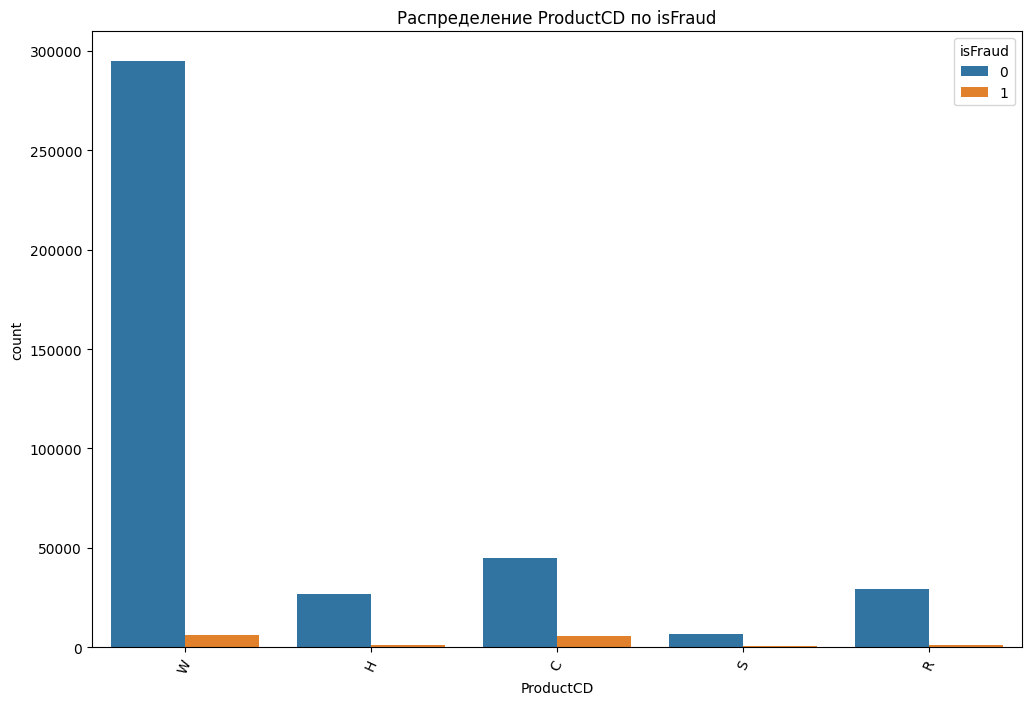

Значения для card4:
4


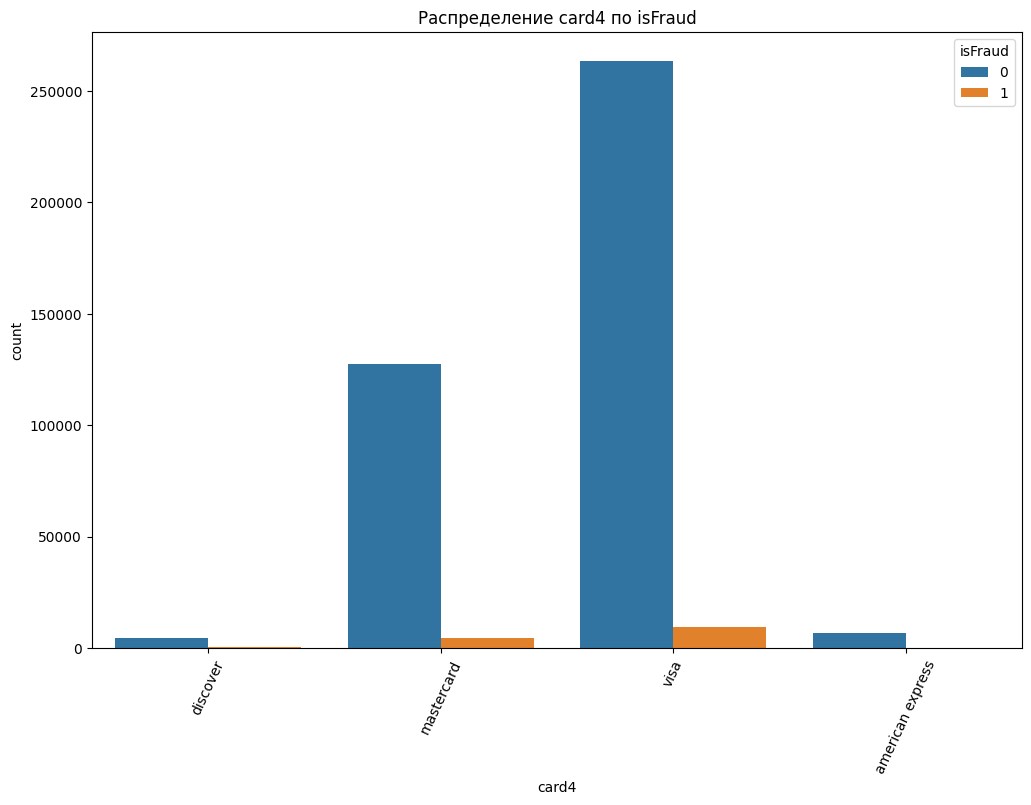

Значения для card6:
4


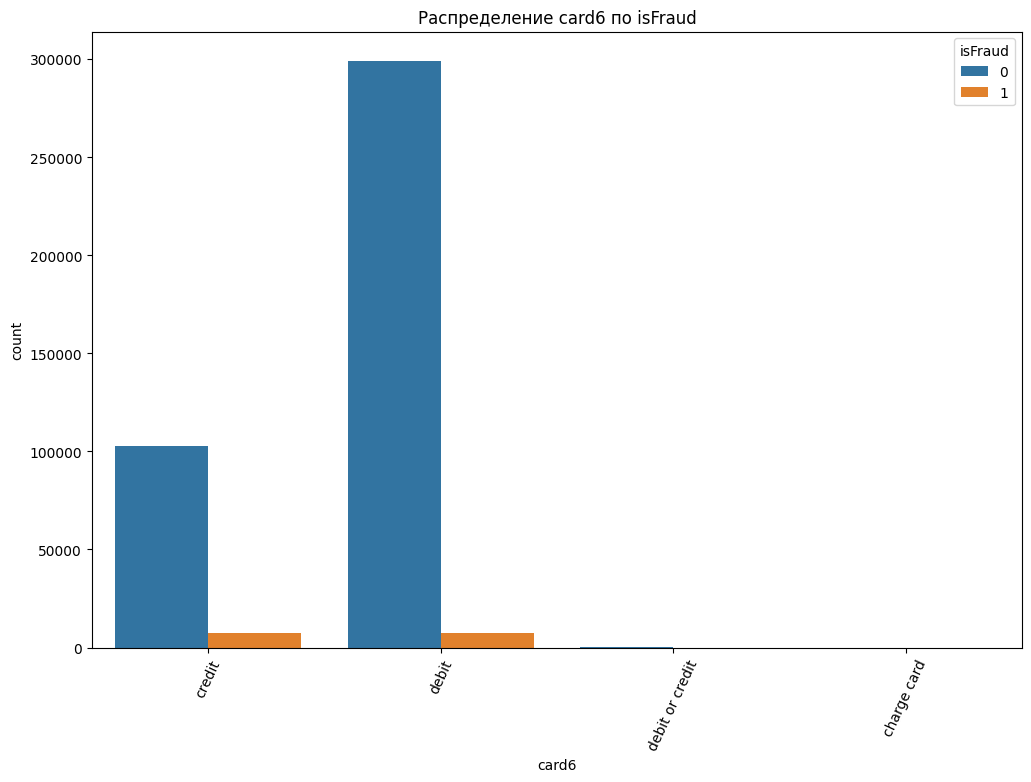

Значения для P_emaildomain:
59
Значения для R_emaildomain:
60
Значения для M1:
2


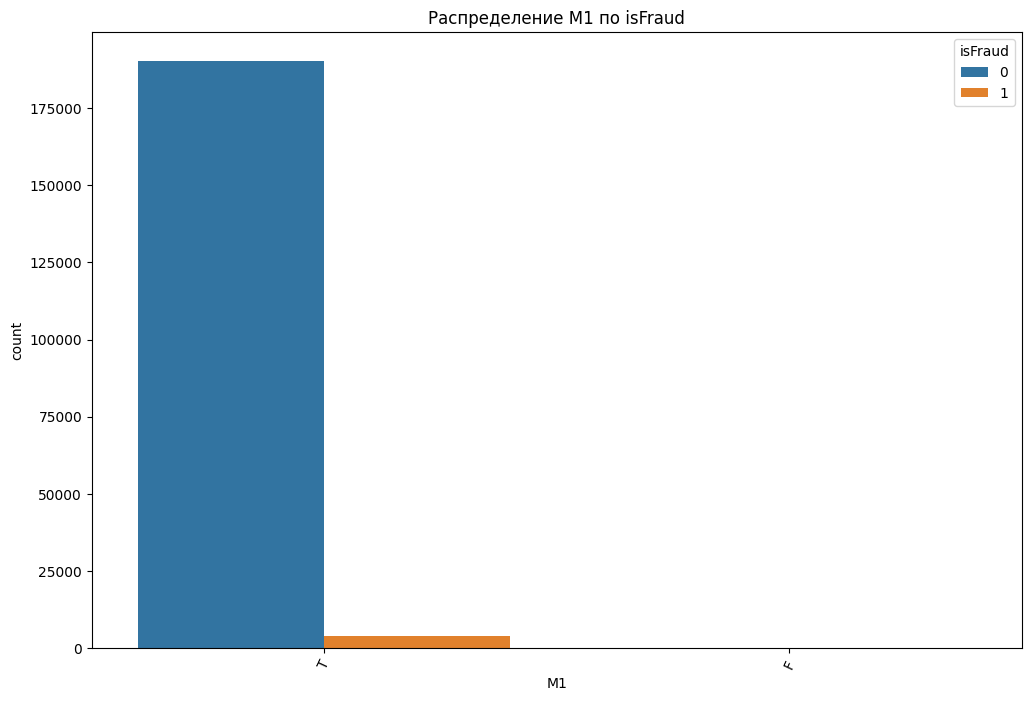

Значения для M2:
2


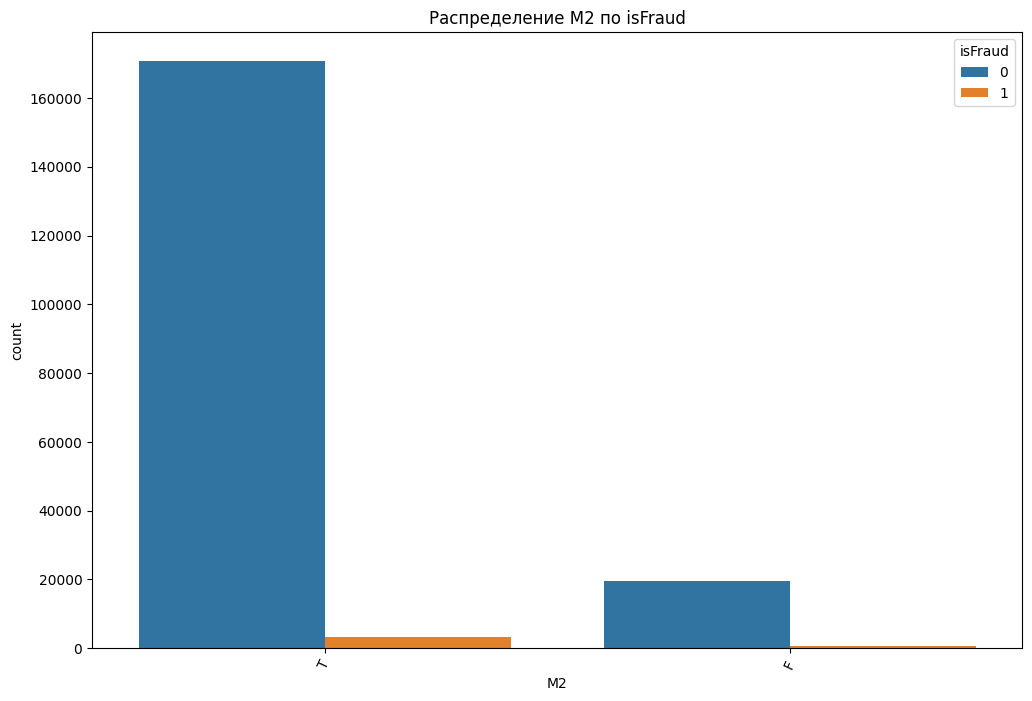

Значения для M3:
2


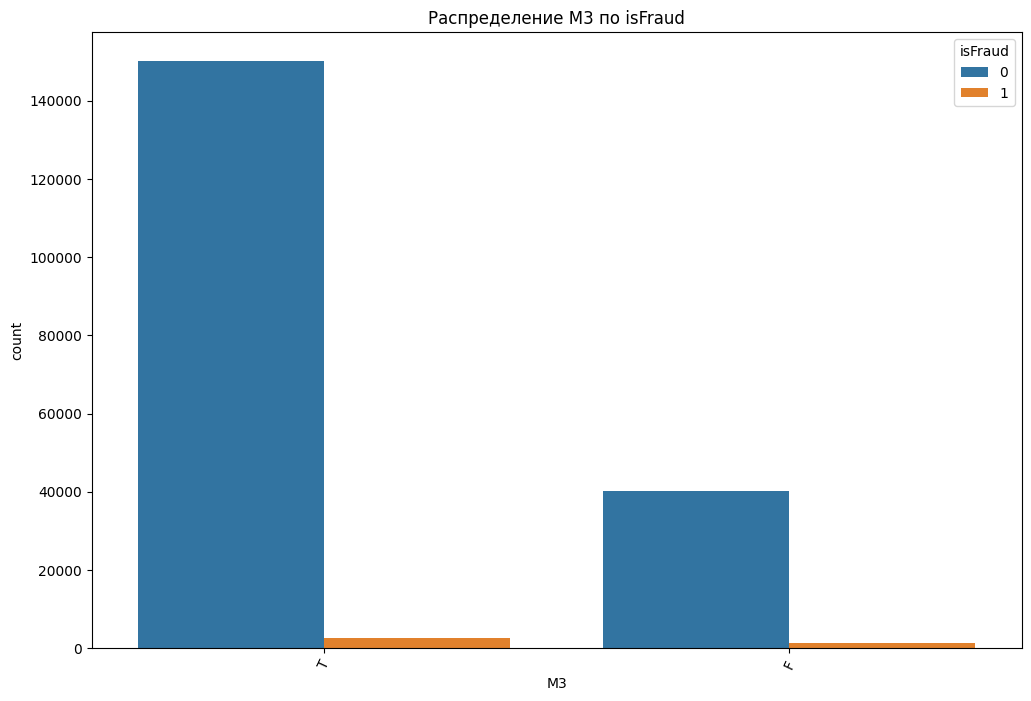

Значения для M4:
3


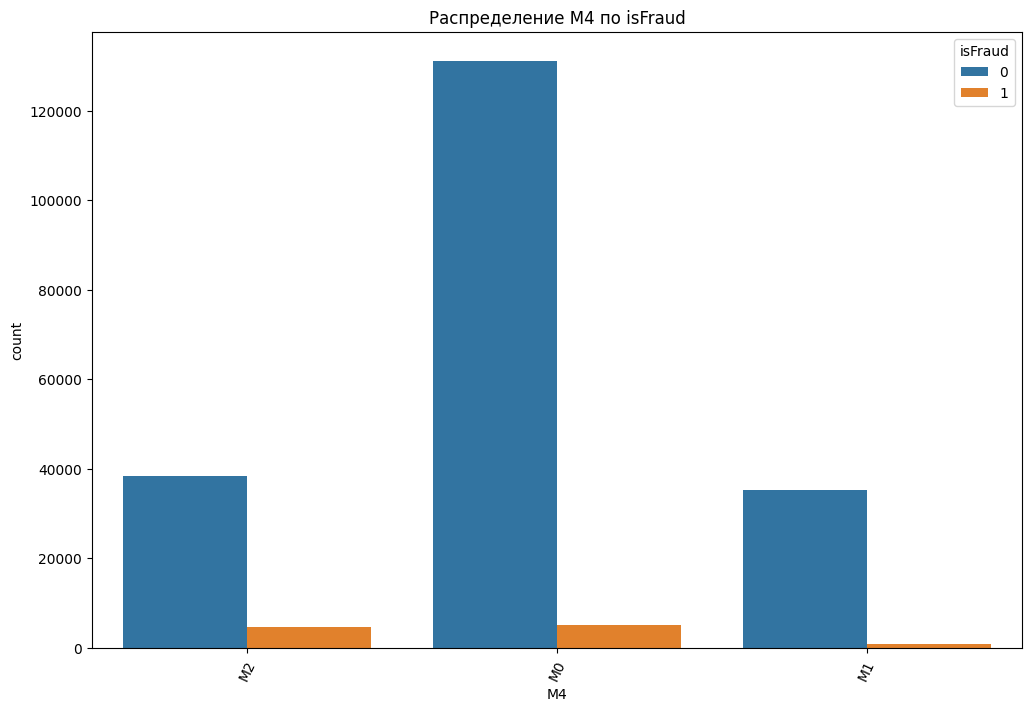

Значения для M5:
2


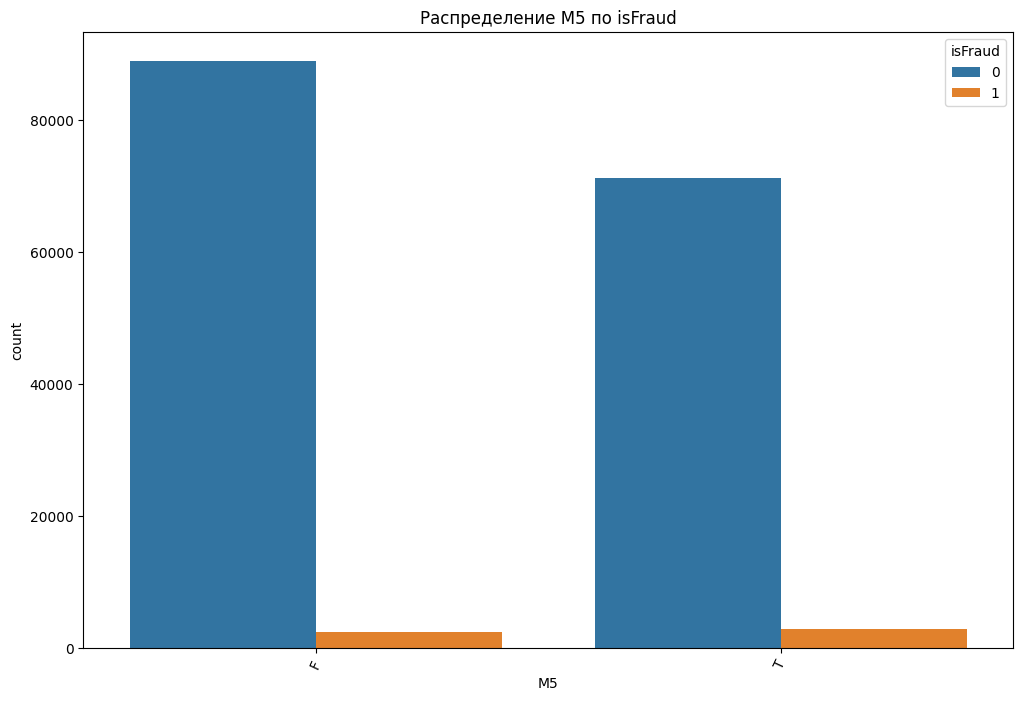

Значения для M6:
2


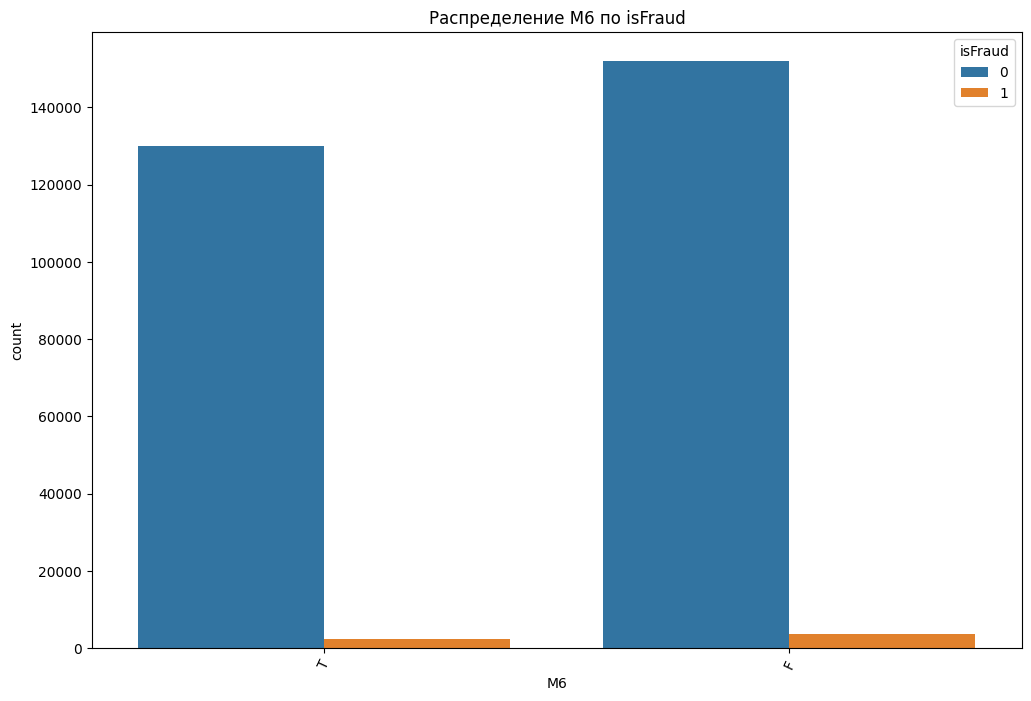

Значения для M7:
2


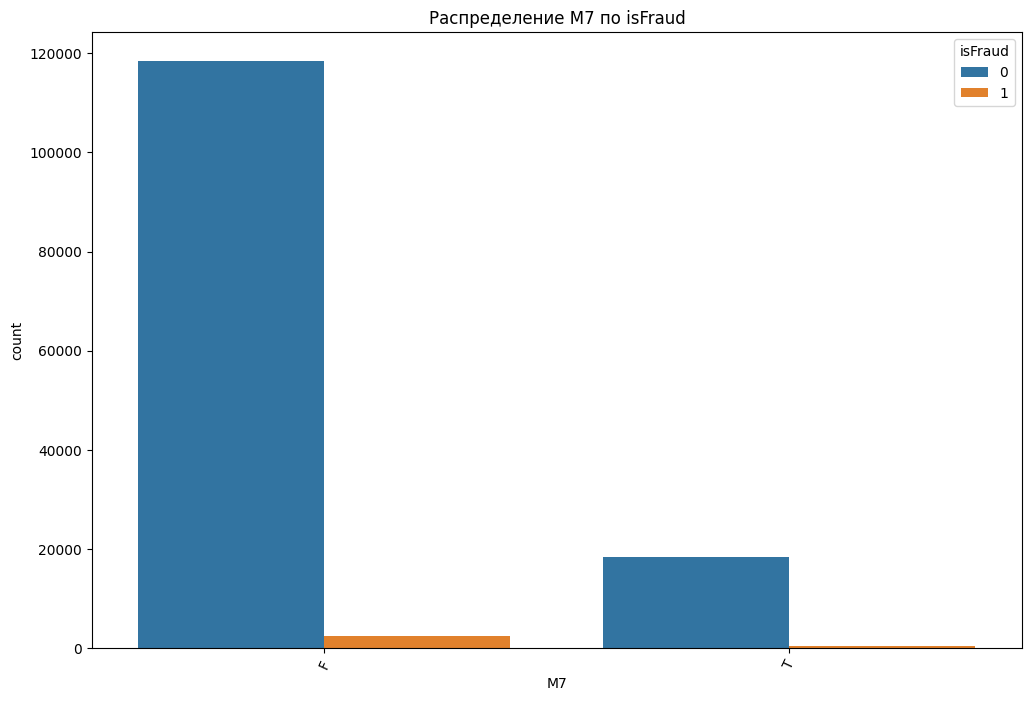

Значения для M8:
2


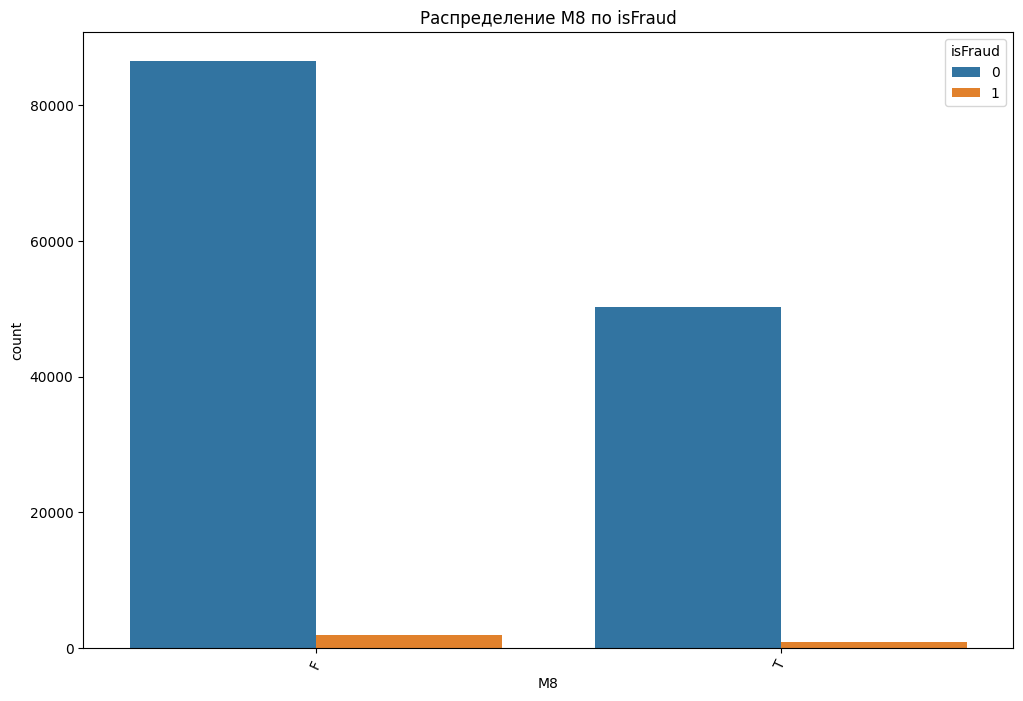

Значения для M9:
2


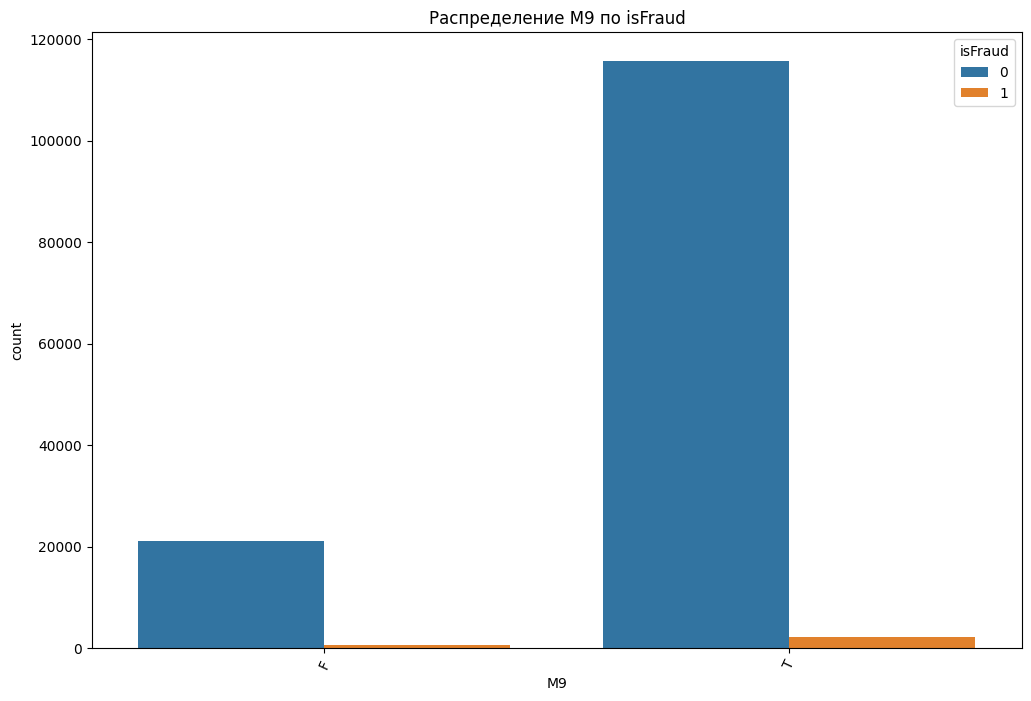

Значения для id_12:
2


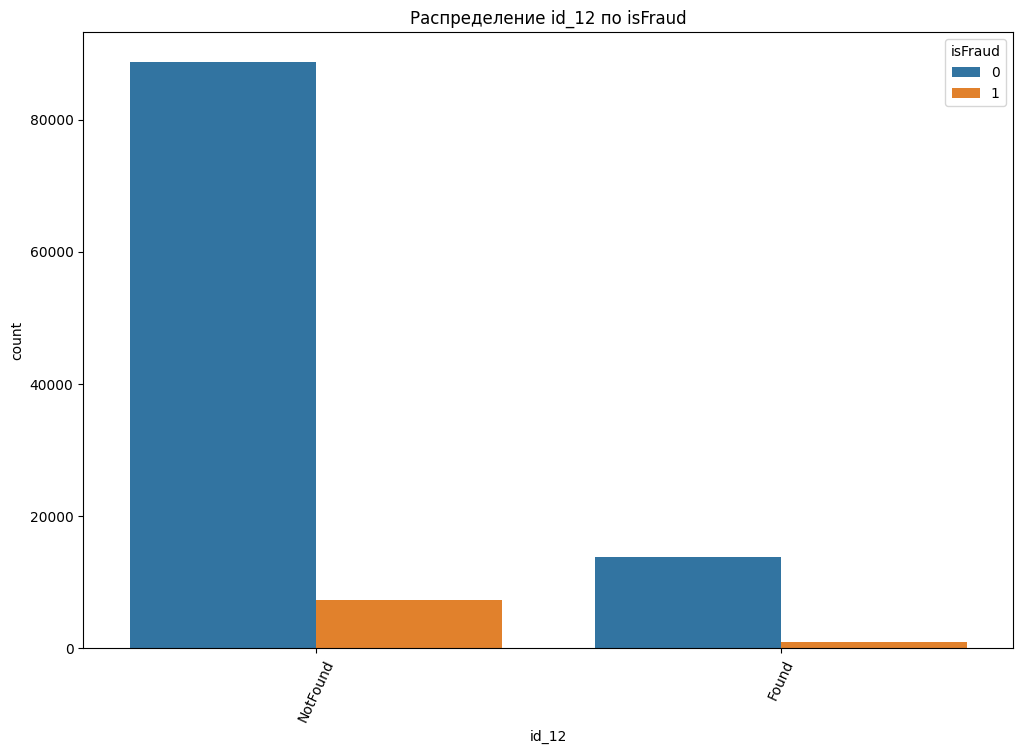

Значения для id_15:
3


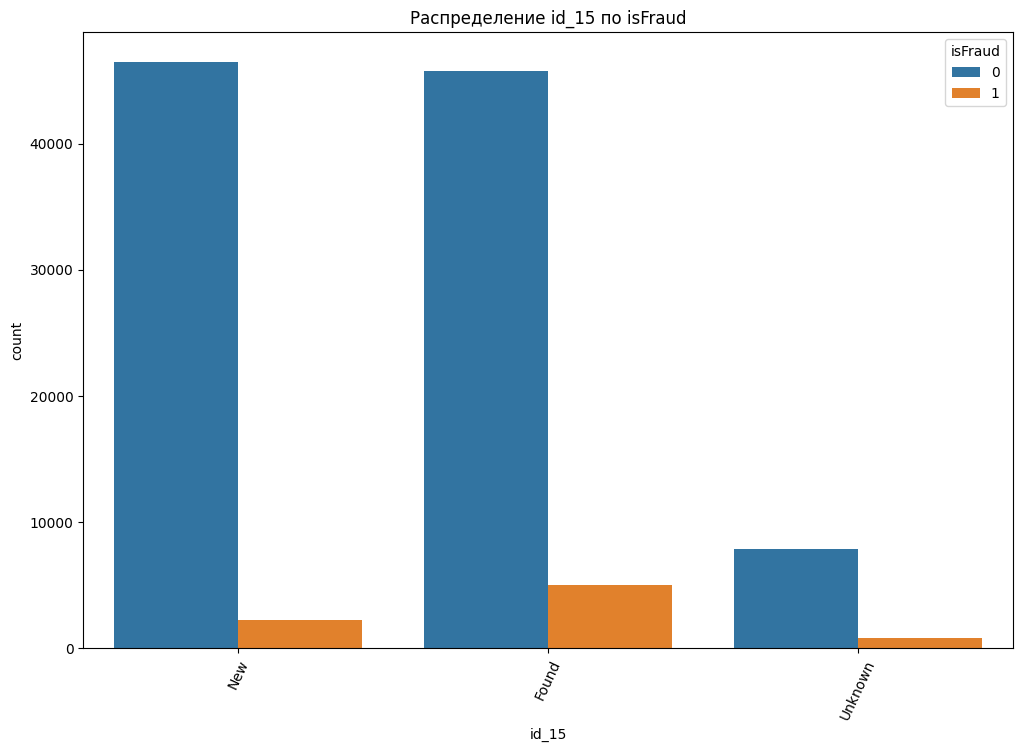

Значения для id_16:
2


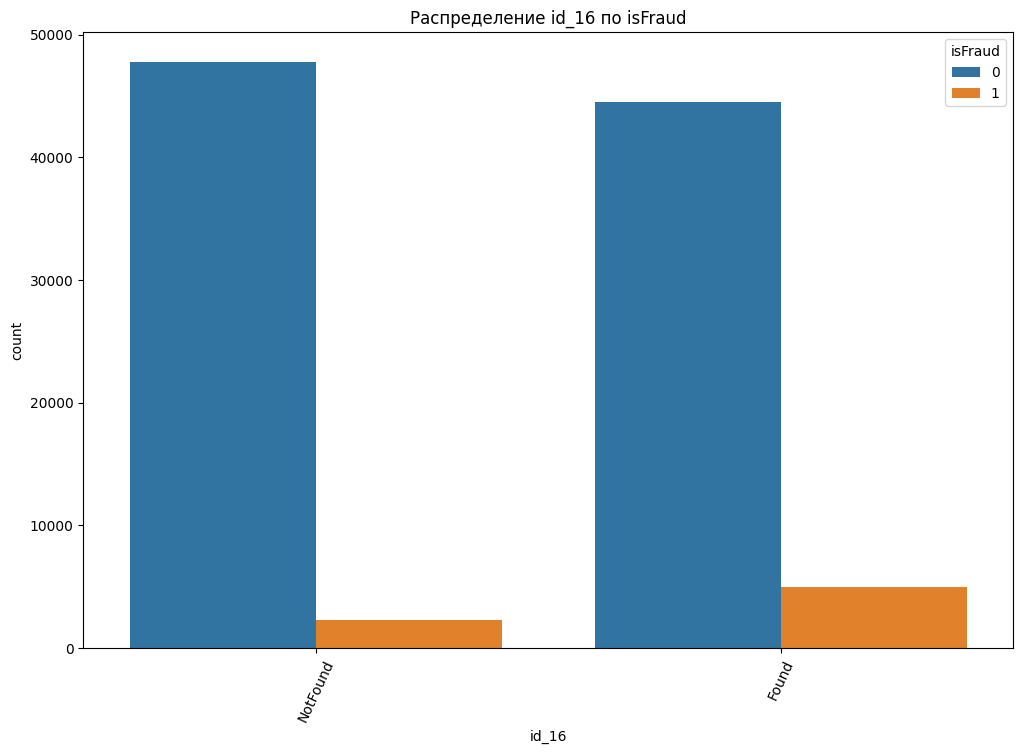

Значения для id_23:
3


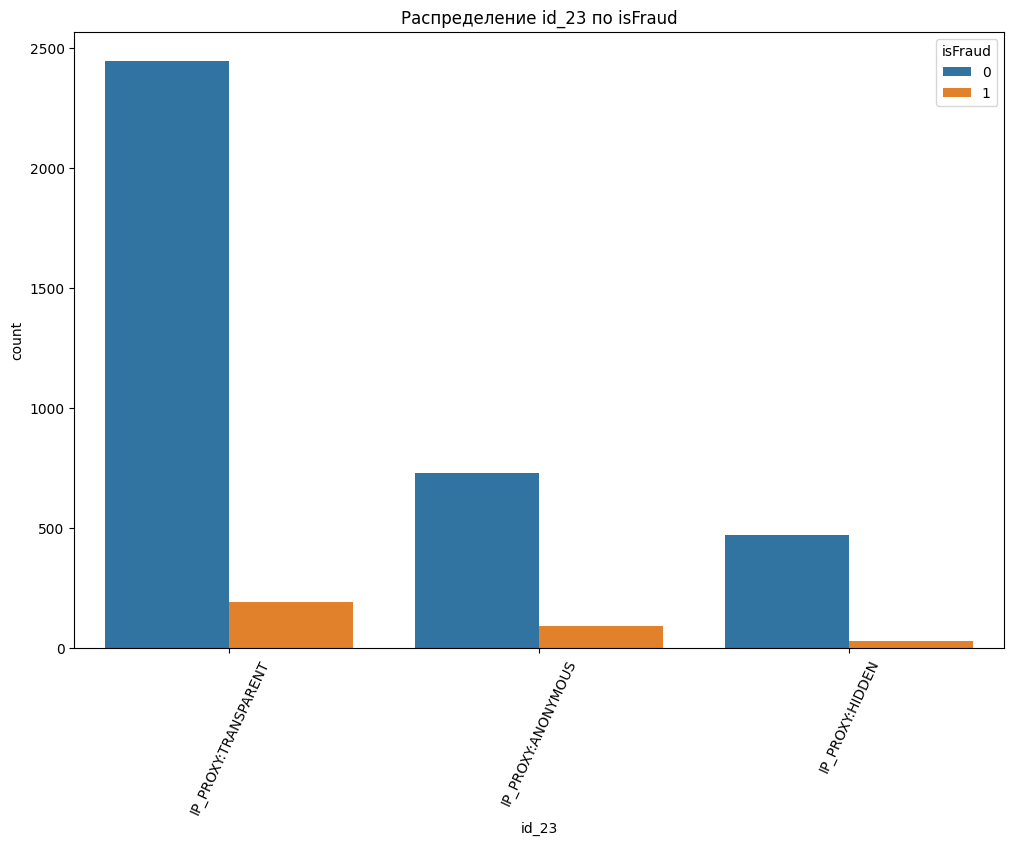

Значения для id_27:
2


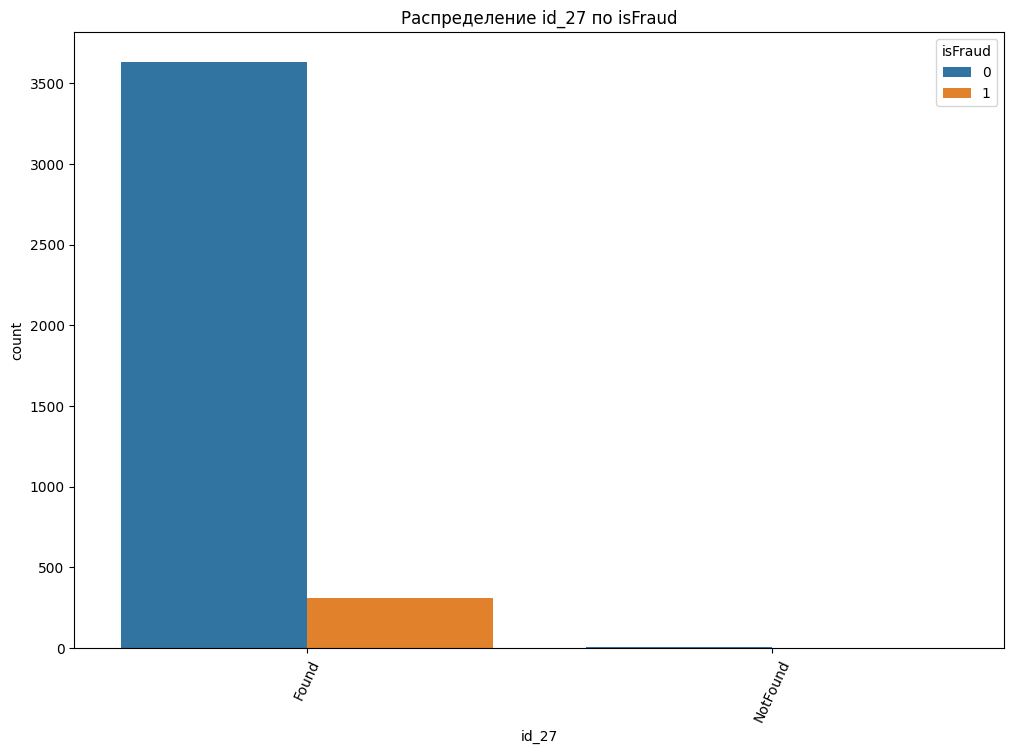

Значения для id_28:
2


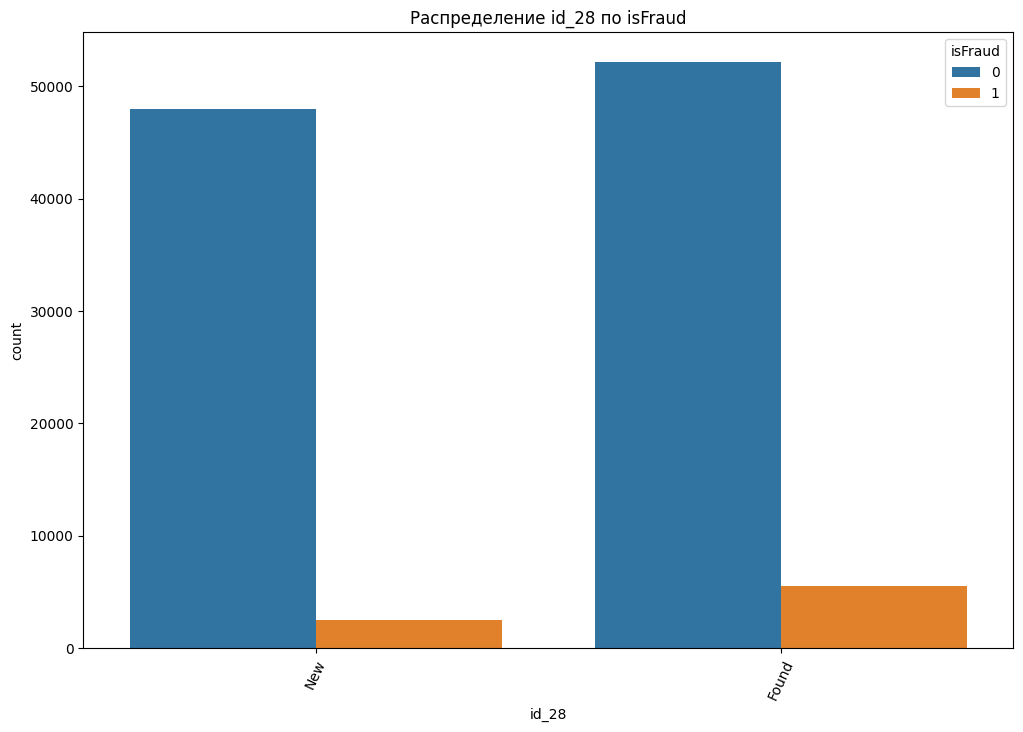

Значения для id_29:
2


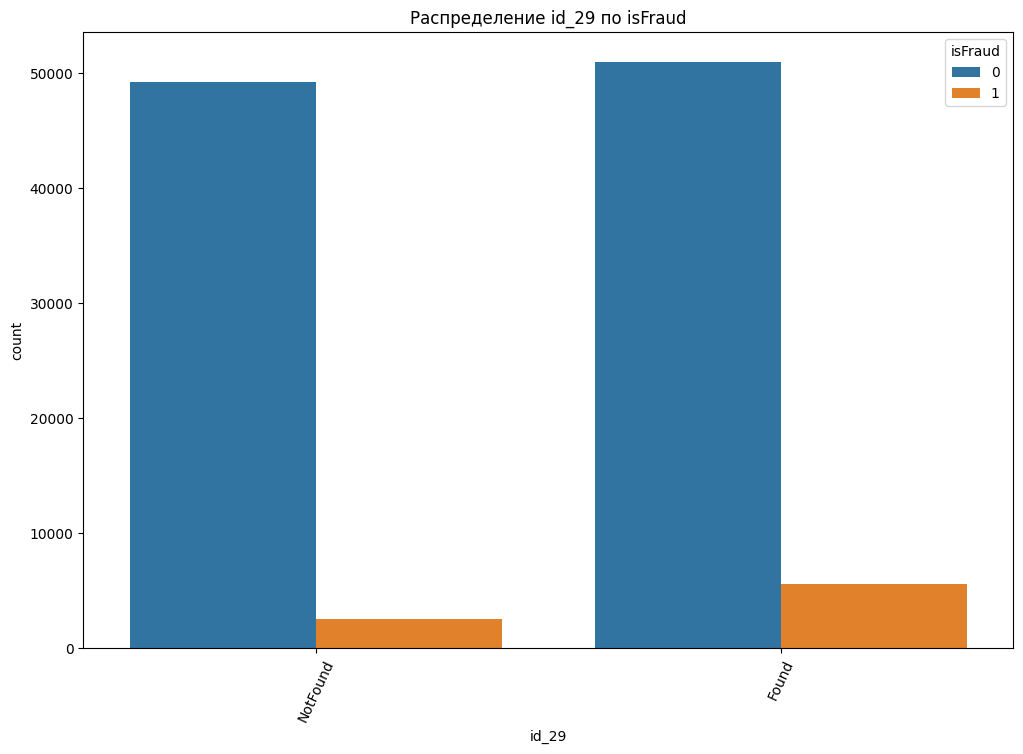

Значения для id_30:
71
Значения для id_31:
110
Значения для id_33:
183
Значения для id_34:
4


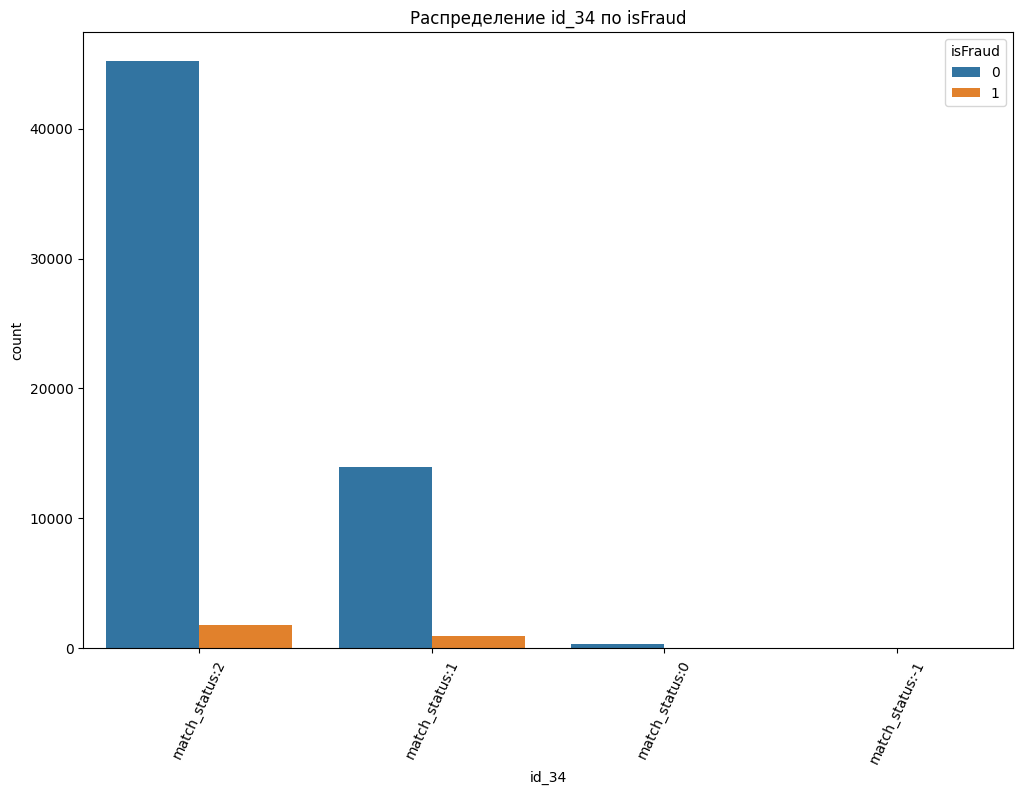

Значения для id_35:
2


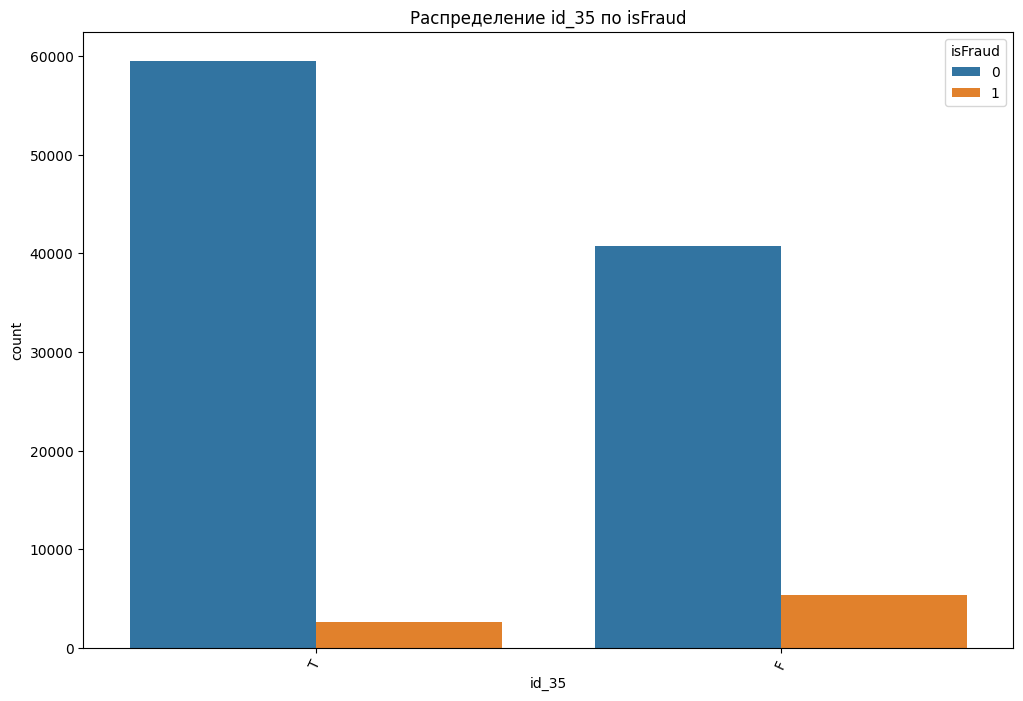

Значения для id_36:
2


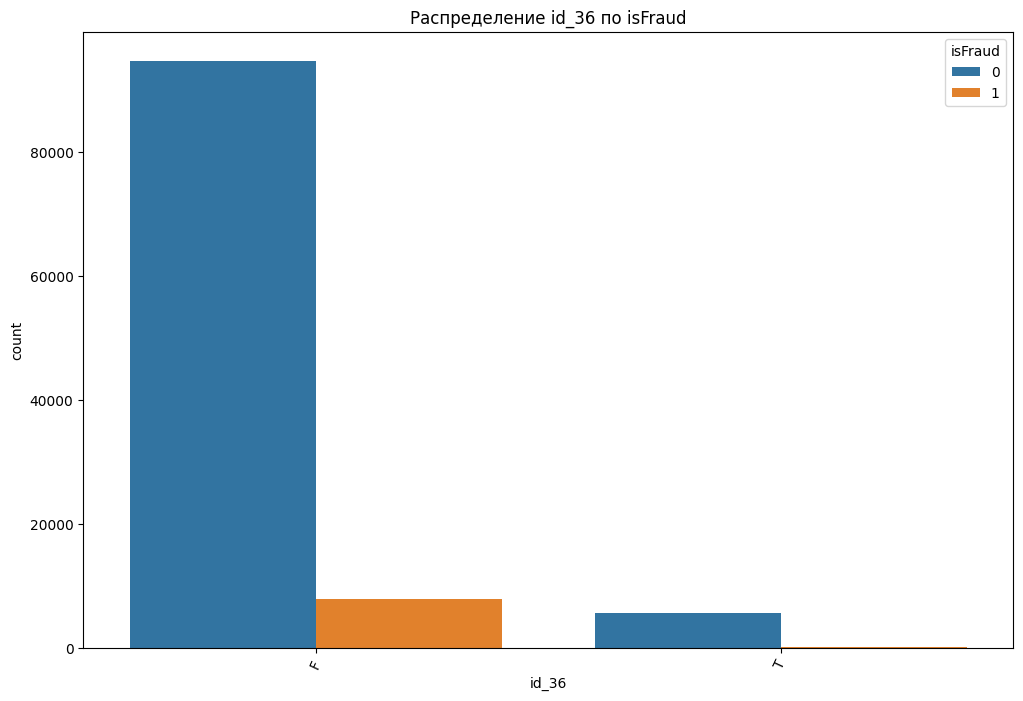

Значения для id_37:
2


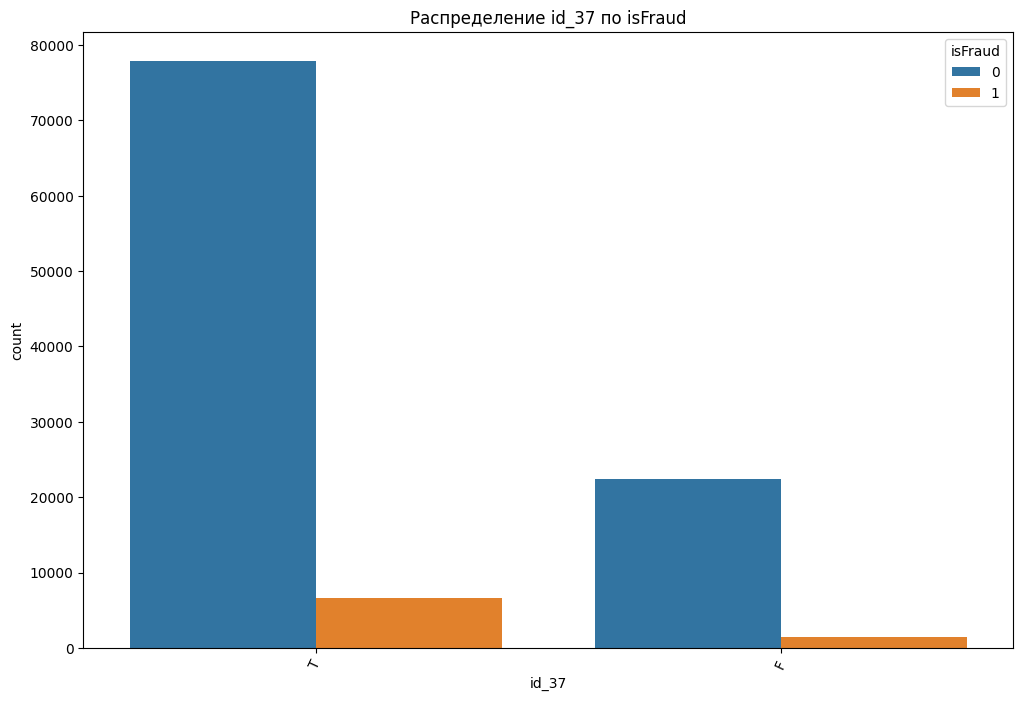

Значения для id_38:
2


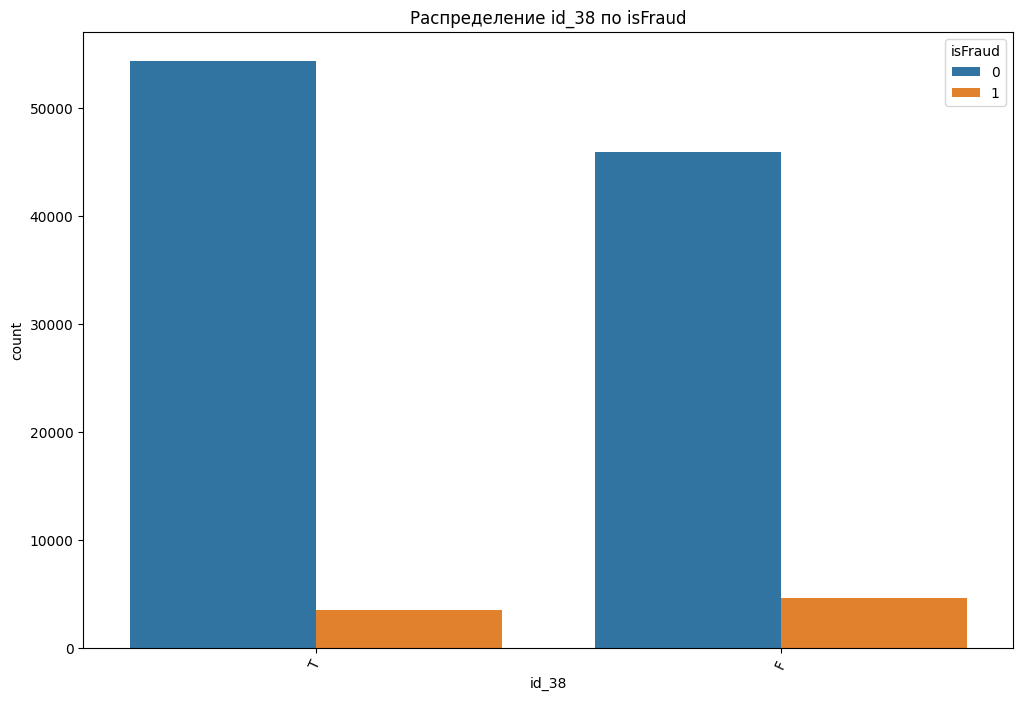

Значения для DeviceType:
2


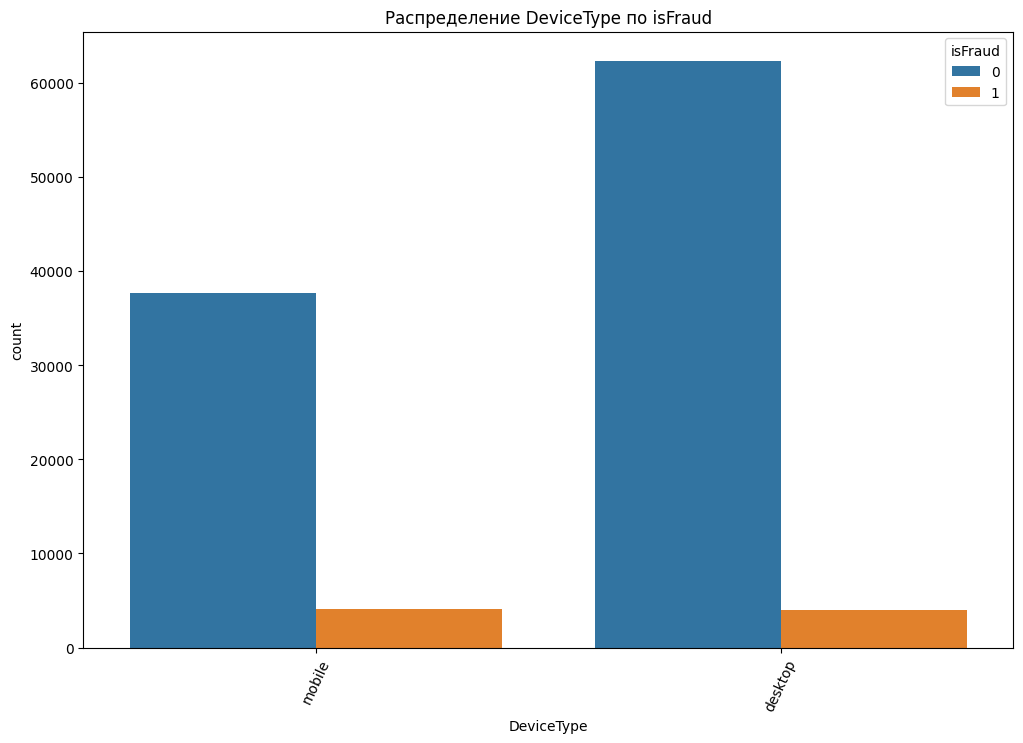

Значения для DeviceInfo:
1551


In [ ]:
# проверим связь с таргетов
for col in cat_col:
    print(f"Значения для {col}:")
    print(df_train[col].nunique())
    if df_train[col].nunique() <= 10:
        plt.figure(figsize=(12, 8))
        sns.countplot(x=col, data=df_train, hue='isFraud')
        plt.title(f'Распределение {col} по isFraud')
        plt.xticks(rotation=65)
        plt.show()

In [ ]:
#Описательная статистика
df_train[cat_col].describe()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,...,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,417559,416730,416733,352649,103820,194116,194116,194116,215646,165564,...,62096,107961,57819,62168,108273,108273,108273,108273,108124,91959
unique,5,4,4,59,60,2,2,2,3,2,...,71,110,183,4,2,2,2,2,2,1551
top,W,visa,debit,gmail.com,gmail.com,T,T,T,M0,F,...,Windows 10,chrome 63.0,1920x1080,match_status:2,T,F,T,T,desktop,Windows
freq,301297,272753,306554,160974,43010,194098,173868,152682,136257,91343,...,16078,21821,13466,46931,62152,102536,84398,57779,66324,36841


Видно по графикам нашим, что фрод-транзакций меньше вне зависимости от значения кат-признака. Также стоит по работать дальше с признаками в целом, там достаочное кол-во уникальных позиций


In [ ]:
# числовые признаки
num_col = list(df_train.select_dtypes(include=['int', 'float']).columns)

In [ ]:
# описательная статистика
df_train[num_col].describe()

,TransactionAmt,D8,D9,V126,V127,V128,V129,V130,V131,V132,...,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_11
count,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,...,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000
mean,134.666550,19.559401,-0.788503,39.691315,155.851883,73.536072,8.606789,80.953400,27.693863,17.669556,...,11.419909,16.080784,13.210349,0.645891,3.083903,1.422102,3.804170,4.682749,4.095501,91.782127
std,238.153122,101.849319,0.548024,346.076385,700.441284,428.552002,125.208633,280.775696,159.563797,226.350479,...,248.493576,292.434235,257.790314,107.641762,125.912041,109.705162,118.905792,128.603714,120.820877,4.763547
min,0.251000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,89.000000
25%,42.950001,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,89.000000
50%,68.949997,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,89.000000
75%,125.000000,-1.000000,-1.000000,0.000000,98.000000,0.000000,0.000000,54.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,96.190002
max,31937.390625,1707.791626,0.958333,65297.171875,65297.171875,65297.171875,55125.000000,55125.000000,55125.000000,63874.781250,...,55125.000000,55125.000000,55125.000000,55125.000000,55125.000000,55125.000000,25000.000000,25000.000000,25000.000000,100.000000


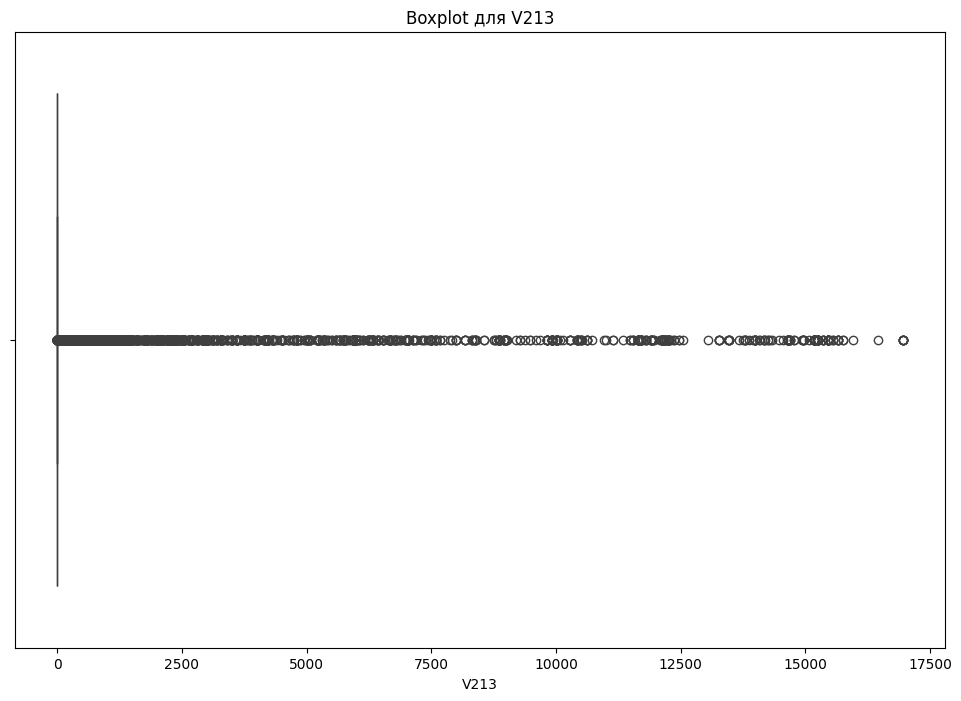

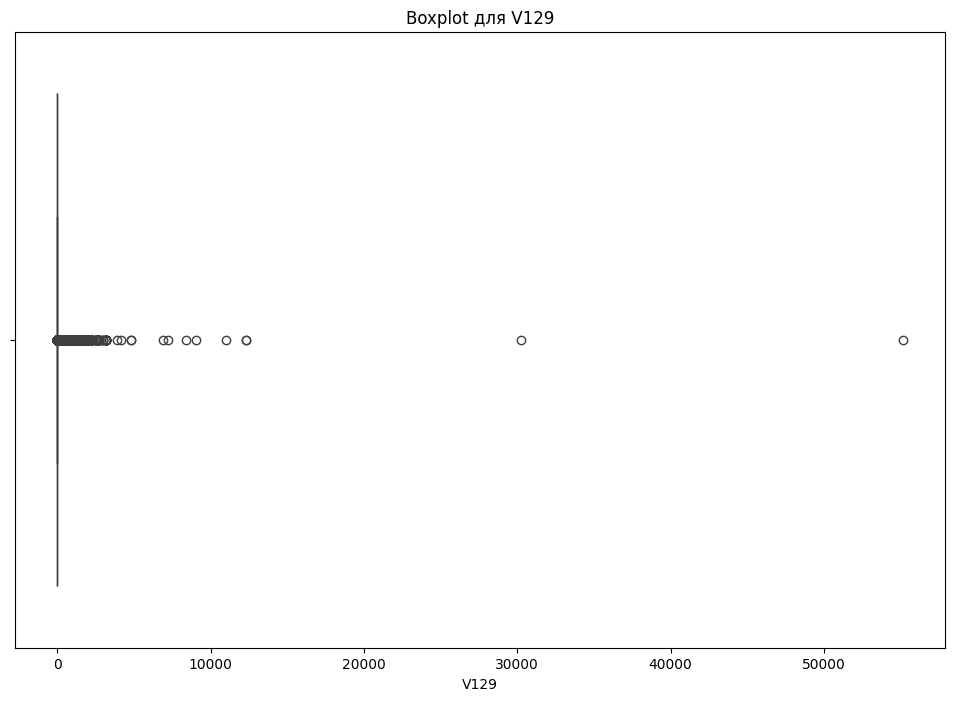

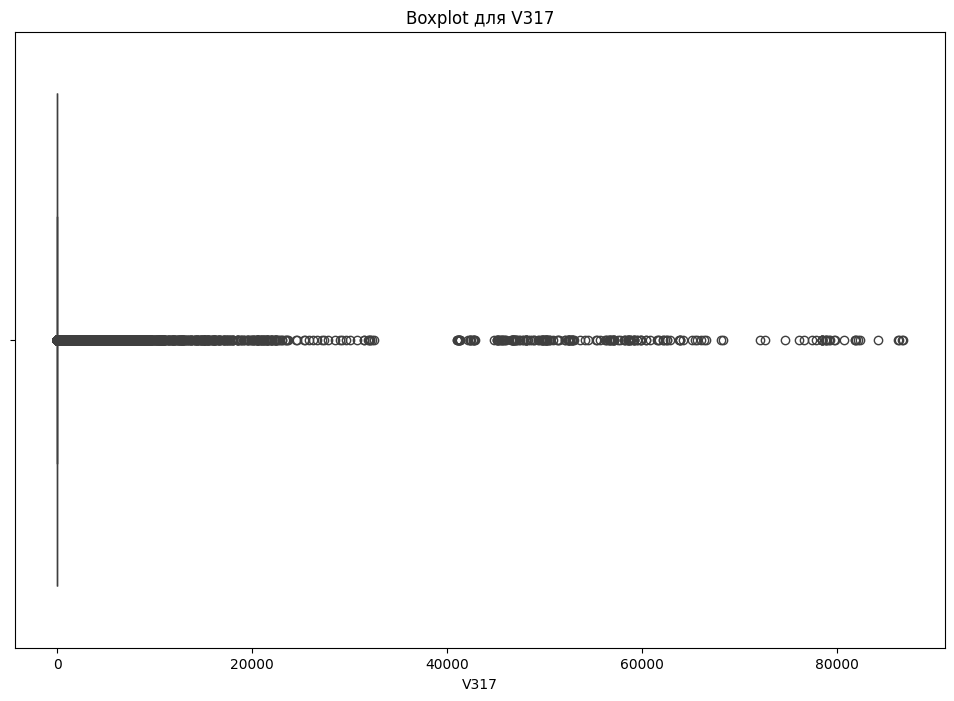

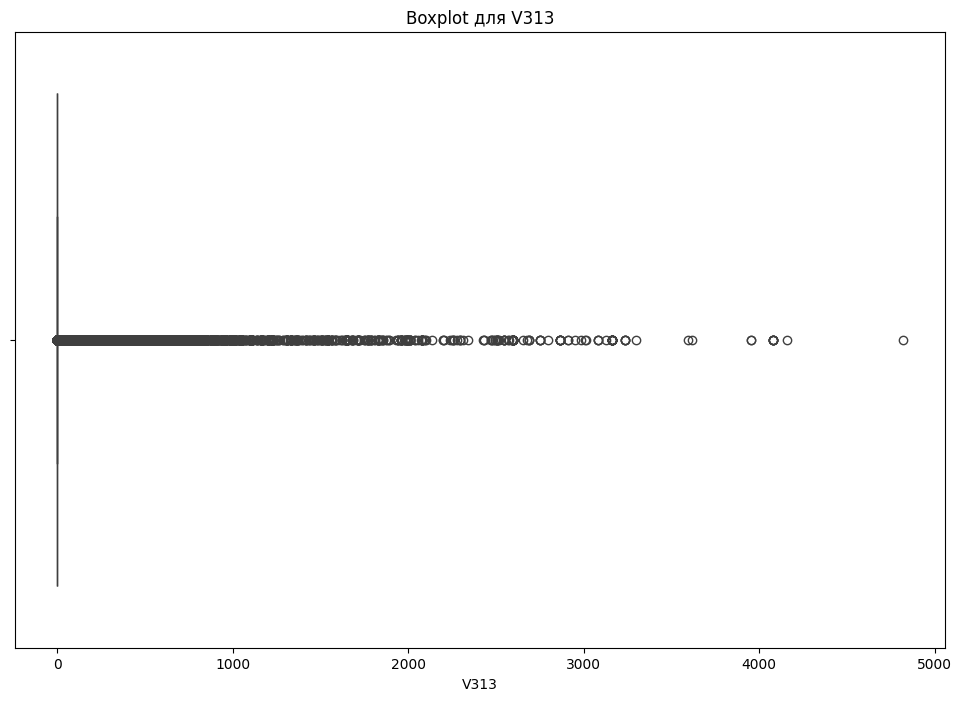

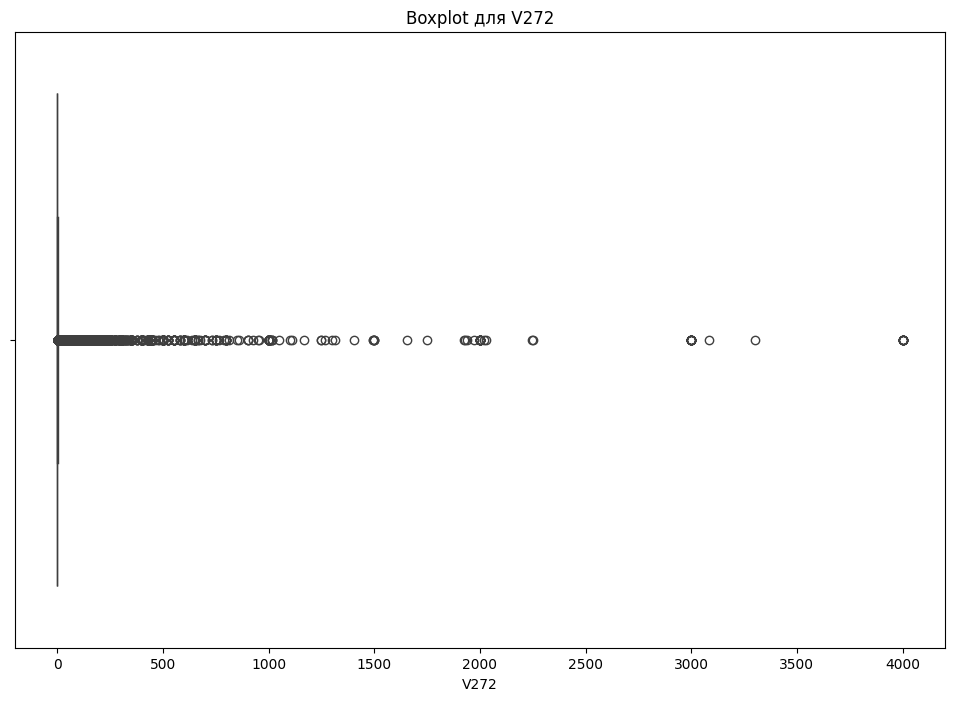

In [ ]:
# посмотим на выбросы для 5-ти случайных признаков
random.seed(52)
random_num_col = random.sample(num_col, 5)

for col in random_num_col:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=df_train[col])
    plt.title(f'Boxplot для {col}')
    plt.show()

По бокслотам видноЮ, что данные очень кучны, где-то присутсвуют аномалии, но они вполне себе могут быть реальными значениями, нет смысла сейчас их как-то дропать

In [ ]:
# распределение таргета
print(df_train['isFraud'].value_counts(normalize=True))

isFraud
0    0.964745
1    0.035255
Name: proportion, dtype: float64


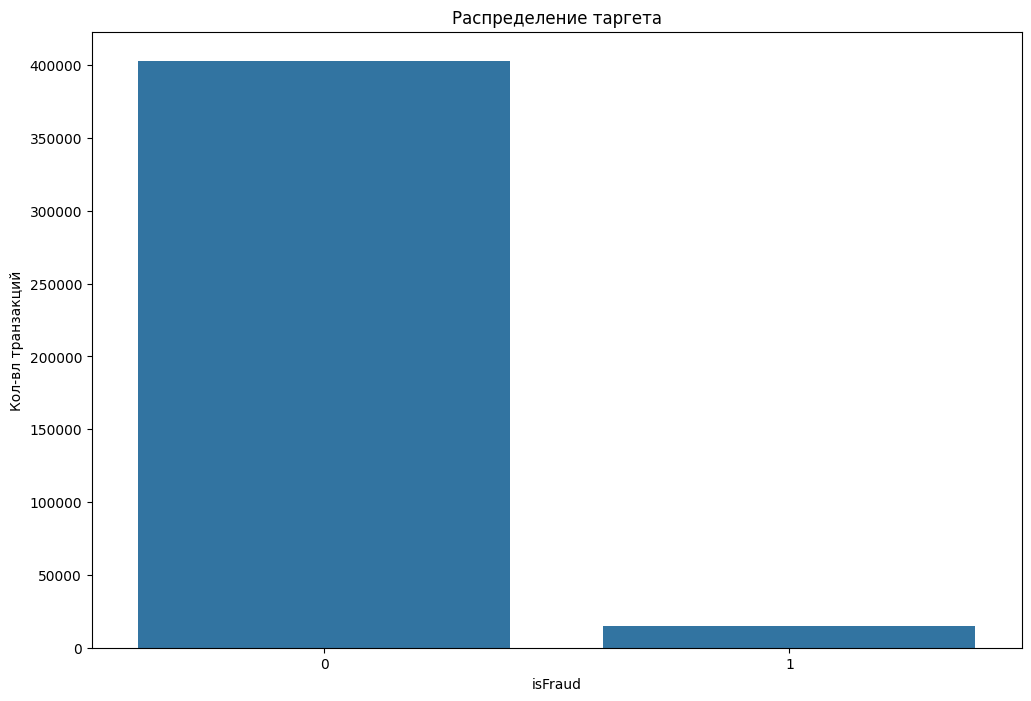

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(x='isFraud', data=df_train)
plt.title('Распределение таргета')
plt.xlabel('isFraud')
plt.ylabel('Кол-вл транзакций')
plt.show()

Дичайший дисбаланс классов

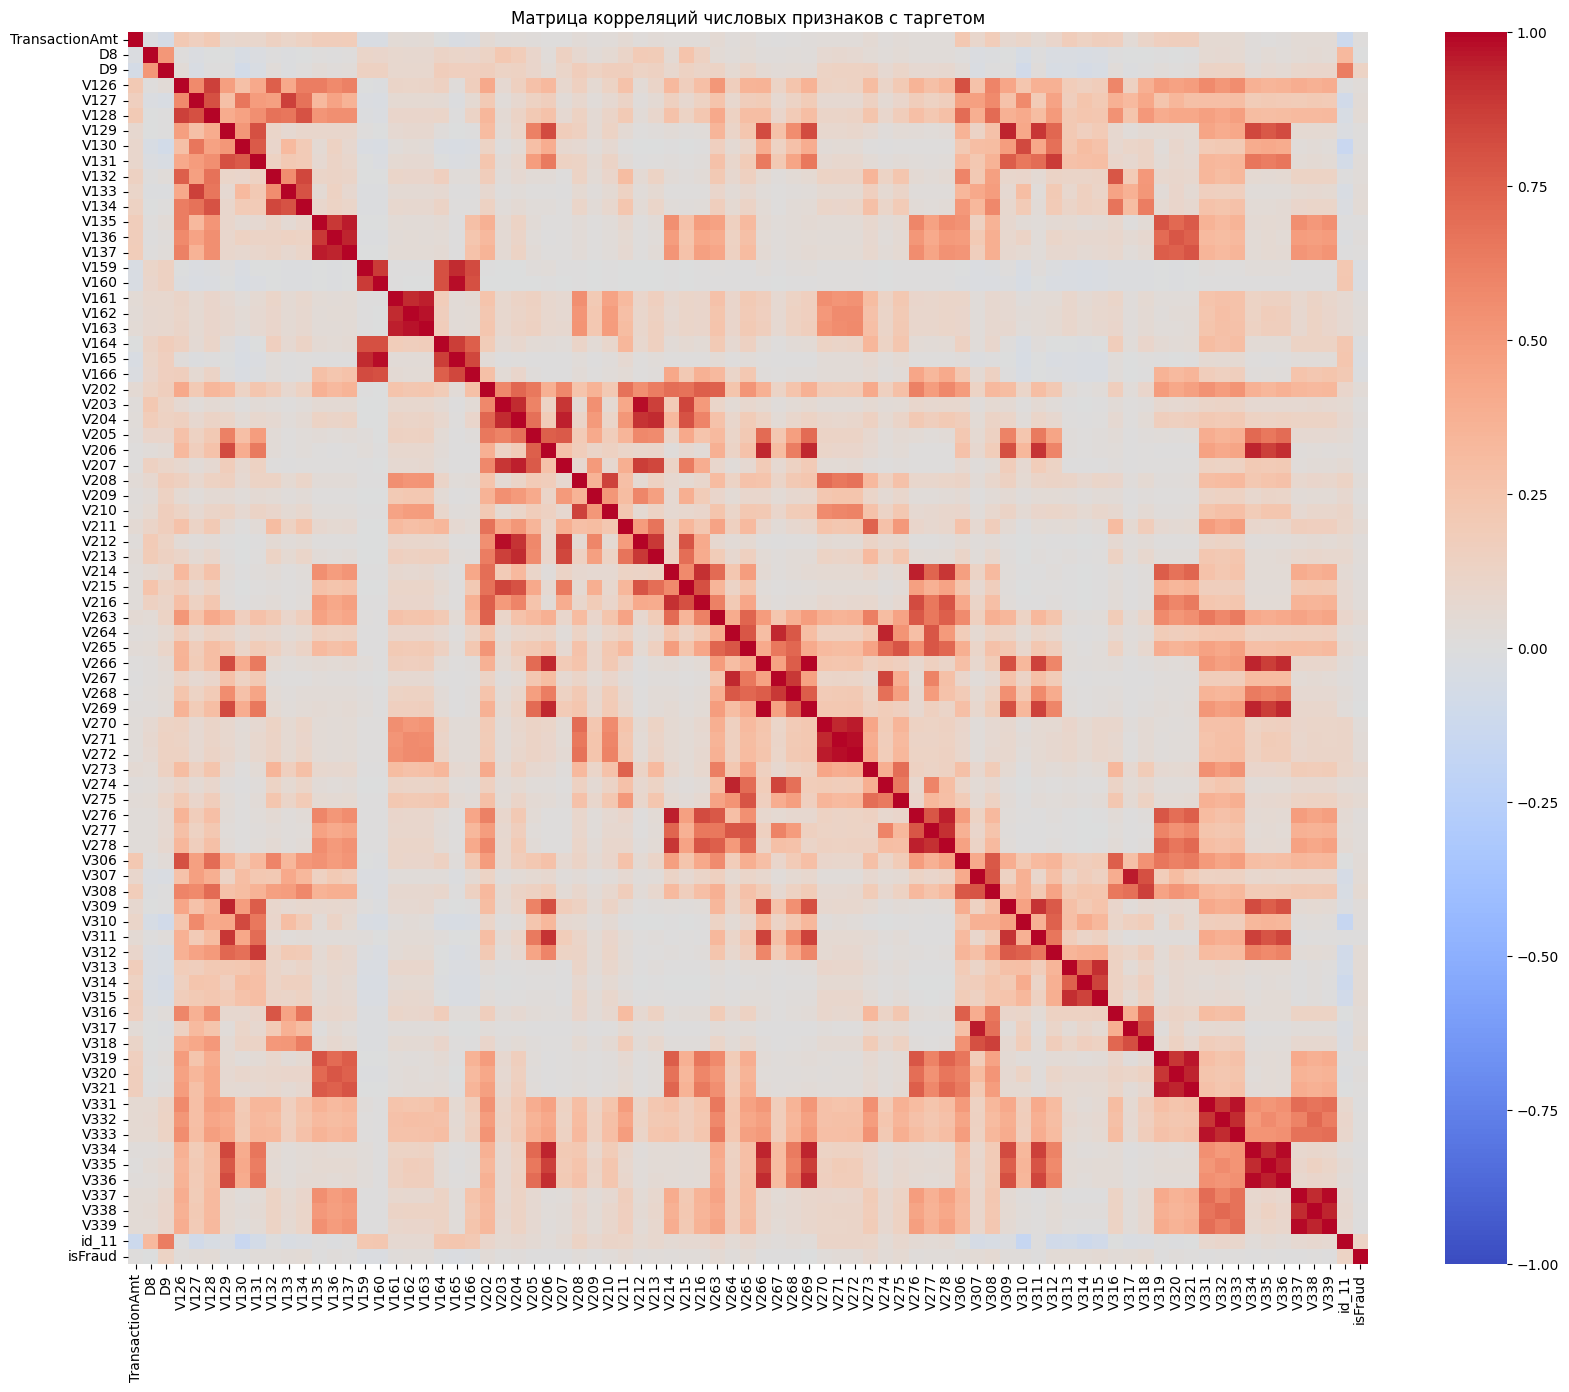

In [ ]:
columns_corr = num_col + ['isFraud']
corr_mat = df_train[columns_corr].corr()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_mat, annot=False, vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Матрица корреляций числовых признаков с таргетом')
plt.show()

выглядит больно, но терпимо

In [ ]:
# corr с таргетом
corr_target = corr_mat['isFraud'].sort_values(ascending=False)
print(corr_target)

isFraud    1.000000
D9         0.126761
id_11      0.126280
V273       0.070597
V308       0.061323
             ...   
V166      -0.010258
V164      -0.014450
V165      -0.021350
V160      -0.022338
V159      -0.022747
Name: isFraud, Length: 81, dtype: float64


Числовые признаки коррелируют с таргетом мягко говоря слаобенько, так же присутсвуют сильные корреляции между самими признаками.

In [ ]:
# проверим все на пропуски
miss = df_train.isna().sum()
miss = (miss / len(df_train)) * 100
miss = miss.sort_values(ascending=False)

print(miss)

id_27    99.053068
id_23    99.053068
id_33    86.153095
id_30    85.128808
id_34    85.111565
           ...    
V97       0.000000
V96       0.000000
V95       0.000000
V94       0.000000
V164      0.000000
Length: 432, dtype: float64


Имеем достаточно большую долю пропусков, в категориальных стобцах можно заменить пропуски на Unknown, числовые оставить пустыми. Дропать такое кол-во ропусков нельзя, иначе поетряем большую часть данных.

In [ ]:
df_train[cat_col] = df_train[cat_col].fillna('Unknown')
df_train[num_col] = df_train[num_col].fillna('')
df_test[cat_col] = df_test[cat_col].fillna('Unknown')
df_test[num_col] = df_test[num_col].fillna('')

In [ ]:
df_train.isna().sum()

,0
isFraud,0
TransactionAmt,0
ProductCD,0
card1,0
card2,0
...,...
id_36,0
id_37,0
id_38,0
DeviceType,0


In [ ]:
df_test.isna().sum()

,0
TransactionAmt,0
ProductCD,0
card1,0
card2,0
card3,0
...,...
id_36,0
id_37,0
id_38,0
DeviceType,0


In [ ]:
# проверим и узнаем кол-во дублей
num_dup_train = df_train.duplicated().sum()
num_dup_test = df_test.duplicated().sum()
print(f"В train: {num_dup_train}")
print(f"В test: {num_dup_test}")

В train: 270
В test: 81


In [ ]:
# удаление дубликатов
df_train = df_train.drop_duplicates().reset_index(drop=True)
# df_test = df_test.drop_duplicates().reset_index(drop=True) (столкнулся с разной размерностью)

In [ ]:
df_train.shape, df_test.shape

((417289, 432), (172981, 431))

In [ ]:
# Закодируем сразу наши признакоми при помощи OHE
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), num_col),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_col)])

# **Задание 2 (3 балла)**

Обучите несколько ML-моделей для решения поставленной задачи.
Оцените их качество двумя способами:

1) на кросс-валидации

2) на лидерборде

Подберите число фолдов на кросс-валидации так, чтобы метрики, которые вы видите, были максимально близки на кросс-валидации и на лидерборде.

По результатам экспериментов постройте таблицу:
* в каждой строке таблицы - результаты одной модели
* по столбцам: качество на кросс-валидации, качество на лидерборде, модель с гиперпараметрами
Полученную таблицу вставьте картинкой прямо в ноутбук после ячеек с кодом. Сделайте текстовые выводы.

In [ ]:
X = df_train.drop(columns=['isFraud'])
y = df_train['isFraud']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=52, stratify=y)

LogReg, CatBoost, LightGBM обучим данные модели

In [ ]:
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))])

logreg_cv_scores = cross_val_score(logreg_pipeline, X_train, y_train, cv=5, scoring='roc_auc')
logreg_cv_mean = logreg_cv_scores.mean()

logreg_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['TransactionAmt', 'D8', 'D9',
                                                   'V126', 'V127', 'V128',
                                                   'V129', 'V130', 'V131',
                                                   'V132', 'V133', 'V134',
                                                   'V135', 'V136', 'V137',
                                                   'V159', 'V160', 'V161',
                                                   'V162', 'V163', 'V164',
                                                   'V165', 'V166', 'V202',
                                                   'V203', 'V204', 'V205',
                                                   'V206', 'V207', 'V208', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ProductCD', 'card4',
                                                   'card6', 'P_emaildomain',
                                                   'R_emaildomain', 'M1', 'M2',
                                                   'M3', 'M4', 'M5', 'M6', 'M7',
                                                   'M8', 'M9', 'id_12', 'id_15',
                                                   'id_16', 'id_23', 'id_27',
                                                   'id_28', 'id_29', 'id_30',
                                                   'id_31', 'id_33', 'id_34',
                                                   'id_35', 'id_36', 'id_37',
                                                   'id_38', 'DeviceType', ...])])),
                ('classifier', LogisticRegression(random_state=42))])

In [ ]:
#logreg_results = {
#    'pipeline': logreg_pipeline,
#    'cv_scores': logreg_cv_scores,
#    'cv_mean': logreg_cv_mean
#}

#dump(logreg_results, 'logreg_results.joblib')

In [ ]:
# LogReg

#logreg_results_loaded = load('/content/logreg_results.joblib')

#logreg_pipeline = logreg_results_loaded['pipeline']
#logreg_cv_scores = logreg_results_loaded['cv_scores']
#logreg_cv_mean = logreg_results_loaded['cv_mean']

In [ ]:
# LogReg
logreg_val_preds = logreg_pipeline.predict_proba(X_val)[:, 1]
logreg_val_score = roc_auc_score(y_val, logreg_val_preds)

print(f'ROC-AUC на кросс-валидации: {logreg_cv_mean:.3f}')
print(f'ROC-AUC на валидационной выборке: {logreg_val_score:.3f}')

ROC-AUC на кросс-валидации: 0.833
ROC-AUC на валидационной выборке: 0.835


ROC-AUC на кросс-валидации: 0.833
ROC-AUC на валидационной выборке: 0.835

In [ ]:
#print("Размер df_test:", df_test.shape)

In [ ]:
#print("Размер sample_submission:", sample_submission.shape)

In [ ]:
#predictions = logreg_pipeline.predict_proba(df_test)
#sub_logreg = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 1]})
#sub_logreg.to_csv('submission_logreg.csv', index=False)

submission_logreg.csv на Kaggle = 0,81880

In [ ]:
#catboost
start_train_time = time.time()

catboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(random_state=52, verbose=100))])

catboost_cv_scores = cross_val_score(catboost_pipeline, X_train, y_train, cv=3, scoring='roc_auc')
catboost_cv_mean = catboost_cv_scores.mean()

catboost_pipeline.fit(X_train, y_train)

end_train_time = time.time()
train_time = end_train_time - start_train_time


Learning rate set to 0.103583
0:	learn: 0.5325954	total: 114ms	remaining: 1m 53s
100:	learn: 0.1041402	total: 12.8s	remaining: 1m 54s
200:	learn: 0.0990853	total: 25s	remaining: 1m 39s
300:	learn: 0.0956175	total: 37.3s	remaining: 1m 26s
400:	learn: 0.0928359	total: 50.8s	remaining: 1m 15s
500:	learn: 0.0903676	total: 1m 2s	remaining: 1m 2s
600:	learn: 0.0881987	total: 1m 14s	remaining: 49.2s
700:	learn: 0.0865233	total: 1m 25s	remaining: 36.3s
800:	learn: 0.0851385	total: 1m 36s	remaining: 24.1s
900:	learn: 0.0835648	total: 1m 48s	remaining: 12s
999:	learn: 0.0822945	total: 2m 1s	remaining: 0us
Learning rate set to 0.103583
0:	learn: 0.5352233	total: 109ms	remaining: 1m 49s
100:	learn: 0.1046163	total: 13.2s	remaining: 1m 57s
200:	learn: 0.0990064	total: 25.4s	remaining: 1m 41s
300:	learn: 0.0954551	total: 36.9s	remaining: 1m 25s
400:	learn: 0.0924424	total: 48.1s	remaining: 1m 11s
500:	learn: 0.0899450	total: 1m	remaining: 1m
600:	learn: 0.0880077	total: 1m 13s	remaining: 48.6s
700:	

In [ ]:
#catboost_results = {
#    'pipeline': catboost_pipeline,
#    'cv_scores': catboost_cv_scores,
#    'cv_mean': catboost_cv_mean}
#dump(catboost_results, 'catboost_results.joblib')

In [ ]:
#catboost_load = load('/content/catboost_results.joblib')

#catboost_pipeline = catboost_load['pipeline']
#catboost_cv_scores = catboost_load['cv_scores']
#catboost_cv_mean = catboost_load['cv_mean']

In [ ]:
start_val_time = time.time()
catboost_val_preds = catboost_pipeline.predict_proba(X_val)[:, 1]
end_val_time = time.time()
val_time = end_val_time - start_val_time

catboost_val_score = roc_auc_score(y_val, catboost_val_preds)

In [ ]:
start_inference_time = time.time()

predictions = catboost_pipeline.predict_proba(df_test)

end_inference_time = time.time()
inference_time = end_inference_time - start_inference_time

In [ ]:
#sub_catboost = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 1]})
#sub_catboost.to_csv('submission_catboost.csv', index=False)

In [ ]:
# значения catboost
print(f'ROC-AUC на кросс-валидации: {catboost_cv_mean:.4f}')
print(f'ROC-AUC на валидационной выборке: {catboost_val_score:.4f}')

ROC-AUC на кросс-валидации: 0.8904
ROC-AUC на валидационной выборке: 0.8969


ROC-AUC на кросс-валидации: 0.8904
ROC-AUC на валидационной выборке: 0.8969

submission_catboost.csv на Kaggle = 0.86342

In [ ]:
print(f'Время обучения: {train_time:.2f} секунд')
print(f'Время инференса на валидационных данных: {val_time:.2f} секунд')
print(f'Время инференса на тестовых данных: {inference_time:.2f} секунд')


Время обучения: 581.79 секунд
Время инференса на валидационных данных: 2.10 секунд
Время инференса на тестовых данных: 6.93 секунд


In [ ]:
# LightGBM
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42, verbose=0))])

lgbm_cv_scores = cross_val_score(lgbm_pipeline, X_train, y_train, cv=5, scoring='roc_auc')
lgbm_cv_mean = lgbm_cv_scores.mean()

lgbm_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['TransactionAmt', 'D8', 'D9',
                                                   'V126', 'V127', 'V128',
                                                   'V129', 'V130', 'V131',
                                                   'V132', 'V133', 'V134',
                                                   'V135', 'V136', 'V137',
                                                   'V159', 'V160', 'V161',
                                                   'V162', 'V163', 'V164',
                                                   'V165', 'V166', 'V202',
                                                   'V203', 'V204', 'V205',
                                                   'V206', 'V207', 'V208', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ProductCD', 'card4',
                                                   'card6', 'P_emaildomain',
                                                   'R_emaildomain', 'M1', 'M2',
                                                   'M3', 'M4', 'M5', 'M6', 'M7',
                                                   'M8', 'M9', 'id_12', 'id_15',
                                                   'id_16', 'id_23', 'id_27',
                                                   'id_28', 'id_29', 'id_30',
                                                   'id_31', 'id_33', 'id_34',
                                                   'id_35', 'id_36', 'id_37',
                                                   'id_38', 'DeviceType', ...])])),
                ('classifier', LGBMClassifier(random_state=42, verbose=0))])

In [ ]:
#lgbm_results = {
#    'pipeline': lgbm_pipeline,
#    'cv_scores': lgbm_cv_scores,
#    'cv_mean': lgbm_cv_mean}

#dump(lgbm_results, 'lgbm_results.joblib')

In [ ]:
#lgbm_load = load('/content/lgbm_results.joblib')

#lgbm_pipeline = lgbm_load['pipeline']
#lgbm_cv_scores = lgbm_load['cv_scores']
#lgbm_cv_mean = lgbm_load['cv_mean']

In [ ]:
#predictions = lgbm_pipeline.predict_proba(df_test)
#sub_lgbm = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 1]})
#sub_lgbm.to_csv('submission_lgbm.csv', index=False)

In [ ]:
lgbm_val_preds = lgbm_pipeline.predict_proba(X_val)[:, 1]
lgbm_val_score = roc_auc_score(y_val, lgbm_val_preds)

print(f'ROC-AUC на кросс-валидации: {lgbm_cv_mean:.3f}')
print(f'ROC-AUC на валидационной выборке: {lgbm_val_score:.3f}')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ROC-AUC на кросс-валидации: 0.891
ROC-AUC на валидационной выборке: 0.894


ROC-AUC на кросс-валидации: 0.891
ROC-AUC на валидационной выборке: 0.894

submission_lgbm на Kaggle = 86910

In [ ]:
# Stacking
catboost_train_preds = catboost_pipeline.predict_proba(X_train)[:, 1]
lgbm_train_preds = lgbm_pipeline.predict_proba(X_train)[:, 1]

stacked_train_preds = np.column_stack((catboost_train_preds, lgbm_train_preds))
meta_model = LGBMClassifier(verbose=0, random_state=52)
meta_model.fit(stacked_train_preds, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LGBMClassifier(random_state=52, verbose=0)

In [ ]:
catboost_val_preds = catboost_pipeline.predict_proba(X_val)[:, 1]
lgbm_val_preds = lgbm_pipeline.predict_proba(X_val)[:, 1]

stack_preds = np.column_stack((catboost_val_preds, lgbm_val_preds))

stack_preds_meta = meta_model.predict_proba(stack_preds)[:, 1]

stack_roc_auc = roc_auc_score(y_val, stack_preds_meta)
print(f'ROC-AUC: {stack_roc_auc:.3f}')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ROC-AUC: 0.897


In [ ]:
catboost_test_preds = catboost_pipeline.predict_proba(df_test)[:, 1]
lgbm_test_preds = lgbm_pipeline.predict_proba(df_test)[:, 1]

stacked_test_preds = np.column_stack((catboost_test_preds, lgbm_test_preds))
test_predictions = meta_model.predict_proba(stacked_test_preds)[:, 1]
sub_meta_model = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': test_predictions})

sub_meta_model.to_csv('submission_meta.csv', index=False)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


submission_meta на Kaggle = 0,86612

In [ ]:
print(f"Model: LogReg, CV ROC-AUC: {logreg_cv_mean:.3f}, Kaggle ROC-AUC: 0.81880")
print(f"Model: CatBoost, CV ROC-AUC: {catboost_cv_mean:.3f}, Kaggle ROC-AUC: 0.86342")
print(f"Model: LightGBM, CV ROC-AUC: {lgbm_cv_mean:.3f}, Kaggle ROC-AUC: 0.86910")
print(f"Model: Stacking, CV ROC-AUC: {stack_roc_auc:.3f}, Kaggle ROC-AUC: 0.86546")

Model: LogReg, CV ROC-AUC: 0.833, Kaggle ROC-AUC: 0.81880
Model: CatBoost, CV ROC-AUC: 0.890, Kaggle ROC-AUC: 0.86342
Model: LightGBM, CV ROC-AUC: 0.891, Kaggle ROC-AUC: 0.86910
Model: Stacking, CV ROC-AUC: 0.897, Kaggle ROC-AUC: 0.86546


По показателям можно выделить то, что в Stacking самый высокий показатель, а на Kaggle самый высокий показатель имеет LightGBM.

# **Задание 3 (2 балла)**

Попробуйте подойти к задаче как к поиску аномалий.

1) Поищите аномалии (фрод) различными рассмотренными в курсе методами и сделайте прогноз на тестовых данных.

Результатом также будет таблица:
* по строкам - методы поиска аномалий
* по столбцам - качество вашего решения на leaderboard

2) Попробуйте встроить поиск аномалий и их удаление в ML-пайплайн: найдите аномалии и что-нибудь с ними сделайте до обучения моделей (можно удалить их, а можно использовать в качестве дополнительных признаков - попробуйте разные стратегии). Результат проверьте на кросс-валидации и на лидерборде, сделайте выводы.

In [ ]:
# isolation forest

isolation_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', IsolationForest(contamination=0.01, random_state=52))
])

isolation_forest_pipeline.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['TransactionAmt', 'D8', 'D9',
                                                   'V126', 'V127', 'V128',
                                                   'V129', 'V130', 'V131',
                                                   'V132', 'V133', 'V134',
                                                   'V135', 'V136', 'V137',
                                                   'V159', 'V160', 'V161',
                                                   'V162', 'V163', 'V164',
                                                   'V165', 'V166', 'V202',
                                                   'V203', 'V204', 'V205',
                                                   'V206', 'V207', 'V208', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ProductCD', 'card4',
                                                   'card6', 'P_emaildomain',
                                                   'R_emaildomain', 'M1', 'M2',
                                                   'M3', 'M4', 'M5', 'M6', 'M7',
                                                   'M8', 'M9', 'id_12', 'id_15',
                                                   'id_16', 'id_23', 'id_27',
                                                   'id_28', 'id_29', 'id_30',
                                                   'id_31', 'id_33', 'id_34',
                                                   'id_35', 'id_36', 'id_37',
                                                   'id_38', 'DeviceType', ...])])),
                ('classifier',
                 IsolationForest(contamination=0.01, random_state=52))])

In [ ]:
isolation_preds = -isolation_forest_pipeline.decision_function(X_val)
isolation_probs = (isolation_preds - isolation_preds.min()) / (isolation_preds.max() - isolation_preds.min())
isolation_score = roc_auc_score(y_val, isolation_probs)
print(f'ROC-AUC: {isolation_score:.3f}')

ROC-AUC: 0.747


In [ ]:
#isolation_test_preds = -isolation_forest_pipeline.decision_function(df_test)
#isolation_test_probs = (isolation_test_preds - isolation_test_preds.min()) / (isolation_test_preds.max() - isolation_test_preds.min())

#sub_isolation_forest = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': isolation_test_probs})
#sub_isolation_forest.to_csv('submission_isolate.csv', index=False)

submission_isolate Kaggle = 0.77380

In [ ]:
# MiniBatch K-Means

kmeans_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('cluster', MiniBatchKMeans(n_clusters=10, random_state=42, batch_size=1000))])

kmeans_pipeline.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['TransactionAmt', 'D8', 'D9',
                                                   'V126', 'V127', 'V128',
                                                   'V129', 'V130', 'V131',
                                                   'V132', 'V133', 'V134',
                                                   'V135', 'V136', 'V137',
                                                   'V159', 'V160', 'V161',
                                                   'V162', 'V163', 'V164',
                                                   'V165', 'V166', 'V202',
                                                   'V203', 'V204', 'V205',
                                                   'V206', 'V207', 'V208', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ProductCD', 'card4',
                                                   'card6', 'P_emaildomain',
                                                   'R_emaildomain', 'M1', 'M2',
                                                   'M3', 'M4', 'M5', 'M6', 'M7',
                                                   'M8', 'M9', 'id_12', 'id_15',
                                                   'id_16', 'id_23', 'id_27',
                                                   'id_28', 'id_29', 'id_30',
                                                   'id_31', 'id_33', 'id_34',
                                                   'id_35', 'id_36', 'id_37',
                                                   'id_38', 'DeviceType', ...])])),
                ('cluster',
                 MiniBatchKMeans(batch_size=1000, n_clusters=10,
                                 random_state=42))])

In [ ]:
centroids = kmeans_pipeline.named_steps['cluster'].cluster_centers_

X_val_transformed = kmeans_pipeline.named_steps['preprocessor'].transform(X_val)
val_distances = np.min(euclidean_distances(X_val_transformed, centroids), axis=1)
val_probs = (val_distances - val_distances.min()) / (val_distances.max() - val_distances.min())

kmeans_val_score = roc_auc_score(y_val, val_probs)
print(f'MiniBatch K-Means ROC-AUC: {kmeans_val_score:.3f}')

MiniBatch K-Means ROC-AUC: 0.724


In [ ]:
#X_test_transformed = kmeans_pipeline.named_steps['preprocessor'].transform(df_test)
#test_distances = np.min(euclidean_distances(X_test_transformed, centroids), axis=1)
#test_probs = (test_distances - test_distances.min()) / (test_distances.max() - test_distances.min())

#sub_kmeans = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': test_probs})
#sub_kmeans.to_csv('submission_kmean.csv', index=False)

submission_kmean Kaggle = 0.74727

In [ ]:
print(f"Method: Isolation Forest, CV ROC-AUC: {isolation_score:.3f}, Kaggle ROC-AUC: 0.77380")
print(f"Method: MiniBatch K-Means, CV ROC-AUC: {kmeans_val_score:.3f}, Kaggle ROC-AUC: 0.74727")

Method: Isolation Forest, CV ROC-AUC: 0.747, Kaggle ROC-AUC: 0.77380
Method: MiniBatch K-Means, CV ROC-AUC: 0.724, Kaggle ROC-AUC: 0.74727


Методы показали метрики хуже, чем обучения моделей

In [ ]:
def remove_outliers_iqr(df, columns, threshold=1.5):
    """
    Функция для удаления выбросов
    """
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [ ]:
X_train_remove = remove_outliers_iqr(X_train, num_col)
y_train_remove = y_train.loc[X_train_remove.index]

In [ ]:
catboost_pipeline_clean = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(random_state=42, verbose=100))])

catboost_cv_scores_clean = cross_val_score(catboost_pipeline_clean, X_train_remove, y_train_remove, cv=3, scoring='roc_auc')
catboost_cv_mean_clean = catboost_cv_scores_clean.mean()

catboost_pipeline_clean.fit(X_train_remove, y_train_remove)

Learning rate set to 0.059221
0:	learn: 0.5672865	total: 17.1ms	remaining: 17.1s
100:	learn: 0.0527213	total: 1.77s	remaining: 15.8s
200:	learn: 0.0510017	total: 3.4s	remaining: 13.5s
300:	learn: 0.0497590	total: 6.22s	remaining: 14.4s
400:	learn: 0.0489312	total: 8.43s	remaining: 12.6s
500:	learn: 0.0483314	total: 11.6s	remaining: 11.6s
600:	learn: 0.0476795	total: 13.2s	remaining: 8.74s
700:	learn: 0.0472249	total: 14.8s	remaining: 6.32s
800:	learn: 0.0467288	total: 16.5s	remaining: 4.09s
900:	learn: 0.0459345	total: 18.2s	remaining: 2s
999:	learn: 0.0455698	total: 19.8s	remaining: 0us
Learning rate set to 0.059222
0:	learn: 0.5708366	total: 15.6ms	remaining: 15.6s
100:	learn: 0.0529216	total: 1.68s	remaining: 15s
200:	learn: 0.0511730	total: 3.28s	remaining: 13s
300:	learn: 0.0498452	total: 4.89s	remaining: 11.4s
400:	learn: 0.0487519	total: 8.77s	remaining: 13.1s
500:	learn: 0.0476231	total: 10.4s	remaining: 10.4s
600:	learn: 0.0467814	total: 12.2s	remaining: 8.08s
700:	learn: 0.04

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['TransactionAmt', 'D8', 'D9',
                                                   'V126', 'V127', 'V128',
                                                   'V129', 'V130', 'V131',
                                                   'V132', 'V133', 'V134',
                                                   'V135', 'V136', 'V137',
                                                   'V159', 'V160', 'V161',
                                                   'V162', 'V163', 'V164',
                                                   'V165', 'V166', 'V202',
                                                   'V203', 'V204', 'V205',
                                                   'V206', 'V207', 'V208', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ProductCD', 'card4',
                                                   'card6', 'P_emaildomain',
                                                   'R_emaildomain', 'M1', 'M2',
                                                   'M3', 'M4', 'M5', 'M6', 'M7',
                                                   'M8', 'M9', 'id_12', 'id_15',
                                                   'id_16', 'id_23', 'id_27',
                                                   'id_28', 'id_29', 'id_30',
                                                   'id_31', 'id_33', 'id_34',
                                                   'id_35', 'id_36', 'id_37',
                                                   'id_38', 'DeviceType', ...])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x78548b1be3d0>)])

In [ ]:
#catboost_results = {
#    'pipeline': catboost_pipeline_clean,
#    'cv_scores': catboost_cv_scores_clean,
#    'cv_mean': catboost_cv_mean_clean}

#dump(catboost_results, 'catboost_results_remove.joblib')

In [ ]:
#catboost_results_loaded = load('/content/catboost_results_remove.joblib')

#catboost_pipeline_clean = catboost_results_loaded['pipeline']
#catboost_cv_scores_clean = catboost_results_loaded['cv_scores']
#catboost_cv_mean_clean = catboost_results_loaded['cv_mean']

In [ ]:
catboost_val_preds_clean = catboost_pipeline_clean.predict_proba(X_val)[:, 1]
catboost_val_score_clean = roc_auc_score(y_val, catboost_val_preds_clean)
print(f'ROC-AUC на кросс-валидации: {catboost_cv_mean_clean:.3f}')
print(f'ROC-AUC на валидационной выборке: {catboost_val_score_clean:.3f}')

ROC-AUC на кросс-валидации: 0.727
ROC-AUC на валидационной выборке: 0.679


In [ ]:
#predictions_clean = catboost_pipeline_clean.predict_proba(df_test)
#sub_catboost = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions_clean[:, 1]})
#sub_catboost.to_csv('submission_catboost_remove.csv', index=False)

submission_catboost_remove Kaggle = 0.68143

Показатели упали

In [ ]:
# бинарные признакми
def add_outlier_feature(df, columns, threshold=1.5):
    """
    Добавляем бинарный признак.
    """
    df['is_outlier'] = 0
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), 'is_outlier'] = 1
    return df

In [ ]:
X_train_outlier = add_outlier_feature(X_train, num_col)
X_val_outlier = add_outlier_feature(X_val, num_col)
df_test_outlier = add_outlier_feature(df_test, num_col)

<ipython-input-67-d9f866d06097>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_outlier'] = 0


In [ ]:
cat_col.append('is_outlier')

In [ ]:
cat_col

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo',
 'is_outlier']

In [ ]:
catboost_pipeline_outlier = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(random_state=52, verbose=100))])

catboost_cv_scores_outlier = cross_val_score(catboost_pipeline_outlier, X_train_outlier, y_train, cv=3, scoring='roc_auc')
catboost_cv_mean_outlier = catboost_cv_scores_outlier.mean()

catboost_pipeline_outlier.fit(X_train_outlier, y_train)

Learning rate set to 0.103583
0:	learn: 0.5421555	total: 120ms	remaining: 1m 59s
100:	learn: 0.1043732	total: 13.2s	remaining: 1m 57s
200:	learn: 0.0991934	total: 25.4s	remaining: 1m 40s
300:	learn: 0.0956031	total: 36.3s	remaining: 1m 24s
400:	learn: 0.0925179	total: 48s	remaining: 1m 11s
500:	learn: 0.0901482	total: 1m	remaining: 1m
600:	learn: 0.0880603	total: 1m 12s	remaining: 48.1s
700:	learn: 0.0862513	total: 1m 24s	remaining: 36s
800:	learn: 0.0848339	total: 1m 36s	remaining: 24s
900:	learn: 0.0833590	total: 1m 49s	remaining: 12s
999:	learn: 0.0821512	total: 2m 1s	remaining: 0us
Learning rate set to 0.103583
0:	learn: 0.5367282	total: 276ms	remaining: 4m 35s
100:	learn: 0.1045438	total: 13s	remaining: 1m 55s
200:	learn: 0.0991658	total: 25.4s	remaining: 1m 41s
300:	learn: 0.0955897	total: 37.7s	remaining: 1m 27s
400:	learn: 0.0925550	total: 50.1s	remaining: 1m 14s
500:	learn: 0.0903449	total: 1m 2s	remaining: 1m 1s
600:	learn: 0.0881818	total: 1m 14s	remaining: 49.5s
700:	learn:

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['TransactionAmt', 'D8', 'D9',
                                                   'V126', 'V127', 'V128',
                                                   'V129', 'V130', 'V131',
                                                   'V132', 'V133', 'V134',
                                                   'V135', 'V136', 'V137',
                                                   'V159', 'V160', 'V161',
                                                   'V162', 'V163', 'V164',
                                                   'V165', 'V166', 'V202',
                                                   'V203', 'V204', 'V205',
                                                   'V206', 'V207', 'V208', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ProductCD', 'card4',
                                                   'card6', 'P_emaildomain',
                                                   'R_emaildomain', 'M1', 'M2',
                                                   'M3', 'M4', 'M5', 'M6', 'M7',
                                                   'M8', 'M9', 'id_12', 'id_15',
                                                   'id_16', 'id_23', 'id_27',
                                                   'id_28', 'id_29', 'id_30',
                                                   'id_31', 'id_33', 'id_34',
                                                   'id_35', 'id_36', 'id_37',
                                                   'id_38', 'DeviceType', ...])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x78548b14fd50>)])

In [ ]:
#catboost_results = {
#    'pipeline': catboost_pipeline_outlier,
#    'cv_scores': catboost_cv_scores_outlier,
#    'cv_mean': catboost_cv_mean_outlier}

#dump(catboost_results, 'catboost_results_outlier.joblib')

In [ ]:
#catboost_results_loaded = load('/content/catboost_results_outlier.joblib')

#catboost_pipeline_outlier = catboost_results_loaded['pipeline']
#catboost_cv_scores_outlier = catboost_results_loaded['cv_scores']
#catboost_cv_mean_outlier = catboost_results_loaded['cv_mean']

In [ ]:
catboost_val_preds_outlier = catboost_pipeline_outlier.predict_proba(X_val_outlier)[:, 1]
catboost_val_score_outlier = roc_auc_score(y_val, catboost_val_preds_outlier)

In [ ]:
print(f'ROC-AUC на кросс-валидации: {catboost_cv_mean_outlier:.3f}')
print(f'ROC-AUC на валидационной выборке: {catboost_val_score_outlier:.3f}')

ROC-AUC на кросс-валидации: 0.890
ROC-AUC на валидационной выборке: 0.897


In [ ]:
#predictions_outlier = catboost_pipeline_outlier.predict_proba(df_test)
#sub_catboost_outlier = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions_outlier[:, 1]})
#sub_catboost_outlier.to_csv('submission_catboost_outlier.csv', index=False)

submission_catboost_outlier Kaggle = 0.86406

Выбросы в лице признаков немного апнули метрику

# **Задание 4 (1 балл)**

Сделайте кластеризацию различными способами. Результаты кластеризации используйте для улучшения ML-решений:

1) Номера кластеров закодируйте (OHE или target-encoding) и добавьте как новые признаки

2) При использовании DBSCAN / HDBSCAN предсказанный шум можно трактовать как найденную аномалию и также добавить ее как новый признак

Проведите различные эксперименты. Проверьте как эти подходы влияют на качество прогнозов по кросс-валидации и на лидерборде, сделайте выводы.

In [ ]:
X_train_processed = preprocessor.transform(X_train)

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=52)
kmeans.fit(X_train_processed)

kmeans_labels = kmeans.labels_

In [ ]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
kmeans_ohe = ohe.fit_transform(kmeans_labels.reshape(-1, 1))

In [ ]:
kmeans_ohe_df = pd.DataFrame(kmeans_ohe, columns=['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])

In [ ]:
X_train_reset = X_train.reset_index(drop=True)
kmeans_ohe_df_reset = kmeans_ohe_df.reset_index(drop=True)

print(X_train_reset.index.equals(kmeans_ohe_df_reset.index))

True


In [ ]:
X_train_with_clusters = pd.concat([X_train_reset, kmeans_ohe_df_reset], axis=1)

In [ ]:
X_val_processed = preprocessor.transform(X_val)

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_val_processed)

kmeans_labels = kmeans.labels_

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
kmeans_ohe = ohe.fit_transform(kmeans_labels.reshape(-1, 1))

kmeans_ohe_df = pd.DataFrame(kmeans_ohe, columns=['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])

X_val_reset = X_val.reset_index(drop=True)
kmeans_ohe_df_reset = kmeans_ohe_df.reset_index(drop=True)

X_val_with_clusters = pd.concat([X_val_reset, kmeans_ohe_df_reset], axis=1)

In [ ]:
catboost_pipeline_ohe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(random_state=42, verbose=100))])

catboost_cv_scores = cross_val_score(catboost_pipeline_ohe, X_train_with_clusters, y_train, cv=3, scoring='roc_auc')
catboost_cv_mean = catboost_cv_scores.mean()

catboost_pipeline_ohe.fit(X_train_with_clusters, y_train)

Learning rate set to 0.103583
0:	learn: 0.5338190	total: 120ms	remaining: 1m 59s
100:	learn: 0.1044871	total: 12.9s	remaining: 1m 54s
200:	learn: 0.0992505	total: 30.2s	remaining: 1m 59s
300:	learn: 0.0952055	total: 42.2s	remaining: 1m 38s
400:	learn: 0.0924826	total: 54.3s	remaining: 1m 21s
500:	learn: 0.0900582	total: 1m 11s	remaining: 1m 11s
600:	learn: 0.0880423	total: 1m 24s	remaining: 55.9s
700:	learn: 0.0863298	total: 1m 35s	remaining: 40.6s
800:	learn: 0.0848374	total: 1m 46s	remaining: 26.5s
900:	learn: 0.0833926	total: 1m 59s	remaining: 13.1s
999:	learn: 0.0822745	total: 2m 10s	remaining: 0us
Learning rate set to 0.103583
0:	learn: 0.5404421	total: 108ms	remaining: 1m 47s
100:	learn: 0.1045481	total: 13.3s	remaining: 1m 58s
200:	learn: 0.0993553	total: 25.5s	remaining: 1m 41s
300:	learn: 0.0955008	total: 37.8s	remaining: 1m 27s
400:	learn: 0.0928680	total: 50.3s	remaining: 1m 15s
500:	learn: 0.0902734	total: 1m 2s	remaining: 1m 2s
600:	learn: 0.0884753	total: 1m 13s	remaining

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['TransactionAmt', 'D8', 'D9',
                                                   'V126', 'V127', 'V128',
                                                   'V129', 'V130', 'V131',
                                                   'V132', 'V133', 'V134',
                                                   'V135', 'V136', 'V137',
                                                   'V159', 'V160', 'V161',
                                                   'V162', 'V163', 'V164',
                                                   'V165', 'V166', 'V202',
                                                   'V203', 'V204', 'V205',
                                                   'V206', 'V207', 'V208', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ProductCD', 'card4',
                                                   'card6', 'P_emaildomain',
                                                   'R_emaildomain', 'M1', 'M2',
                                                   'M3', 'M4', 'M5', 'M6', 'M7',
                                                   'M8', 'M9', 'id_12', 'id_15',
                                                   'id_16', 'id_23', 'id_27',
                                                   'id_28', 'id_29', 'id_30',
                                                   'id_31', 'id_33', 'id_34',
                                                   'id_35', 'id_36', 'id_37',
                                                   'id_38', 'DeviceType', ...])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x78548b15b1d0>)])

In [ ]:
#catboost_ohe_results = {
#    'pipeline': catboost_pipeline_ohe,
#    'cv_scores': catboost_cv_scores,
#    'cv_mean': catboost_cv_mean}

#dump(catboost_ohe_results, 'catboost_ohe_results.joblib')

In [ ]:
#catboost_results_loaded = load('/content/catboost_ohe_results.joblib')

#catboost_pipeline_ohe = catboost_results_loaded['pipeline']
#catboost_cv_scores = catboost_results_loaded['cv_scores']
#catboost_cv_mean = catboost_results_loaded['cv_mean']

In [ ]:
catboost_val_preds = catboost_pipeline_ohe.predict_proba(X_val_with_clusters)[:, 1]
catboost_val_score = roc_auc_score(y_val, catboost_val_preds)

In [ ]:
print(f'ROC-AUC на кросс-валидации: {catboost_cv_mean:.3f}')
print(f'ROC-AUC на валидационной выборке: {catboost_val_score:.3f}')

ROC-AUC на кросс-валидации: 0.890
ROC-AUC на валидационной выборке: 0.897


ROC-AUC на кросс-валидации: 0.890
ROC-AUC на валидационной выборке: 0.897

In [ ]:
#predictions = catboost_pipeline_ohe.predict_proba(df_test)
#sub_catboost = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 1]})
#sub_catboost.to_csv('submission_catboost_ohe.csv', index=False)

submission_catboost_ohe Kaggle = 0.86326

Немного ухудшилась метрика из-за кластеров

In [ ]:
# снизим размерность из-за долгого обучения
pca = PCA(n_components=10, random_state=52)
X_train_reduced = pca.fit_transform(X_train_processed)

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(X_train_reduced)

In [ ]:
X_train_dbscan = X_train.copy()
X_train_dbscan['dbscan_cluster'] = dbscan_clusters
X_train_dbscan['dbscan_noise'] = (dbscan_clusters == -1).astype(int)

In [ ]:
# DBSCAN
dbscan_clustrs = {'dbscan': dbscan_clusters}
dump(dbscan_clustrs, 'dbscan_clustrs.joblib')

In [ ]:
dbscan_results_loaded = load('/content/dbscan_clustrs.joblib')
dbscan_clusters = dbscan_results_loaded['dbscan']


In [ ]:
X_val_reduced = pca.transform(X_val_processed)
dbscan_clusters_val = dbscan.fit_predict(X_val_reduced)

In [ ]:
dump({'dbscan_val': dbscan_clusters_val}, 'dbscan_clusters_val.joblib')

In [ ]:
dbscan_results_loaded = load('/content/dbscan_clusters_val.joblib')
dbscan_clusters_val = dbscan_results_loaded['dbscan_val']

In [ ]:
X_val_dbscan = X_val.copy()
X_val_dbscan['dbscan_cluster'] = dbscan_clusters_val
X_val_dbscan['dbscan_noise'] = (dbscan_clusters_val == -1).astype(int)

In [ ]:
catboost_pipeline_dbscan = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(random_state=42, verbose=100))])

catboost_cv_scores = cross_val_score(catboost_pipeline_dbscan, X_train_dbscan, y_train, cv=3, scoring='roc_auc')
catboost_cv_mean = catboost_cv_scores.mean()

catboost_pipeline_dbscan.fit(X_train_dbscan, y_train)

In [ ]:
#catboost_dbscan_results = {
#    'pipeline': catboost_pipeline_dbscan,
#    'cv_scores': catboost_cv_scores,
#    'cv_mean': catboost_cv_mean}

#dump(catboost_dbscan_results, 'catboost_dbscan_results.joblib')

In [ ]:
#catboost_results_loaded = load('/content/catboost_dbscan_results.joblib')

#catboost_pipeline_dbscan = catboost_results_loaded['pipeline']
#catboost_cv_scores = catboost_results_loaded['cv_scores']
#catboost_cv_mean = catboost_results_loaded['cv_mean']

In [ ]:
catboost_val_preds = catboost_pipeline_dbscan.predict_proba(X_val_dbscan)[:, 1]
catboost_val_score = roc_auc_score(y_val, catboost_val_preds)

In [ ]:
print(f'ROC-AUC на кросс-валидации: {catboost_cv_mean:.3f}')
print(f'ROC-AUC на валидационной выборке: {catboost_val_score:.3f}')

In [ ]:
#predictions = catboost_pipeline_dbscan.predict_proba(df_test)
#sub_catboost = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 1]})
#sub_catboost.to_csv('submission_catboost_dbscan.csv', index=False)

Запечатлю на всякий случай сразу тут, потому что боюсь, что колаб упадет
* ROC-AUC на кросс-валидации: 0,891
* ROC-AUC на валидационной выборке:0,898

submission_catboost_dbscan Kaggle = Cannot submit
Your team has used its daily Submission allowance (10) today, please try again tomorrow UTC (7.4 hours from now). :(

В целом качество немного улучшилось, но может это из-за того, что я достаотчно сильно обрезал данные.

## **Задание 5 (1 балл)**

Примените какой-нибудь (один любой) AutoML фреймворк для решения поставленной задачи.

Отправьте AutoML-прогноз на kaggle и посмотрите на качество модели. Сделайте текстовые выводы.

In [ ]:
#!pip install h2o

In [ ]:
#import h2o
#from h2o.automl import H2OAutoML

In [ ]:
#h2o.init()

In [ ]:
#train = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
#val = h2o.H2OFrame(pd.concat([X_val, y_val], axis=1))
#test = h2o.H2OFrame(df_test)


In [ ]:
#x = train.columns
#y = "isFraud"
#x.remove(y)

#train[y] = train[y].asfactor()
#val[y] = val[y].asfactor()

In [ ]:
#aml = H2OAutoML(max_models=20, seed=42, max_runtime_secs=300)
#aml.train(x=x, y=y, training_frame=train, validation_frame=val)

In [ ]:
#preds = aml.leader.predict(test)
#preds_df = preds.as_data_frame()

#test_df = test.as_data_frame()
#test_df['isFraud'] = preds_df['p1']

#sub_h2o = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': test_df['isFraud']})
#sub_h2o.to_csv('submission_h2o.csv', index=False)

In [ ]:
#h2o.cluster().shutdown()

Я бы хотел попробовть использовать данную библиотеку, но соревнованитя на Kaggle закончилось, по этому какие-то выводы по ней сказать ен могу. но думая, она бы немного поднял метрику.

# **Задание 6 (1 балл)**

Весь курс мы работали в Google Colab. Но всегда должны быть запасные варианты, где Вы будете обучать модели.

Среди вариантов есть:
* ваша локальная машина
* kaggle notebooks
* yandex cloud
и другие.

Кроме привычного Google Colab выберите из списка выше один любой альтернативный вариант и проведите эксперимент:

* Прогоните ваш лучший по качеству по результатам заданий 2-4 ML-пайплайн заново в Google Colab и с помощью библиотек (например, при помощи библиотеки time) замерьте время обучения и отдельно время инференса на тестовых данных

* Прогоните этот пайплайн на выбранном альтернативном сервисе/локальной машине и также замерьте время обучения и инференса.

Текстом напишите выводы: опишите, какое альтернативное место для обучения моделей Вы использовали? Прикрепите прямо в ноутбук скриншот с экраном кода в альтернативном сервисе/на локальной машине. Также в виде таблицы приведите сравнение времени обучения и инференса в колабе и в альтернативном месте. Сделайте выводы.

Сделаю локальный вывод, что на своей машине обучение было бы куда быстрее и лучше в разы. Это и так понятно, пытался сделать на Kaggle но там тоже достаточно долго крутиться все. Ну а CatBoost показал просто хорошие результаты на всем протяжении датасета

# **Бонус: за Kaggle и стремление к хорошим скорам (2 балла)**

В этом домашнем задании Ваша цель - не просто выполнить шаги выше, но и построить максимально хорошую по качеству модель.

**К 10 вы можете получить до двух дополнительных баллов:**

* За попадание в топ-20% на private leaderboard — +1 дополнительный балл к оценке
* За попадание в топ-5 мест на private leaderboard — + еще один дополнительный балл к оценке (то есть суммарно 2 дополнительных балла)

**ВАЖНО!!!**

Эти баллы ставятся до мягкого дедлайна по соревнованию. После мягкого дедлайна лидерборд не обновляется, и дополнительные баллы не ставятся.

Успехов!

In [ ]:
# не забудьте прикрепить скриншоты лидерборда, пожалуйста